# Introduction

The goals of this analysis is to inject all mapped motif sequences into random sequences in order to assess how the variable affinities influence binding and accessibility. We will do this with individual mapped motif affinities, paired motifs at selected distances and affinities, and motif arragements mapped across in vivo sequences to see the total combinatorial impact independent of non-motif grammar.

# Computational setup

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

#Packages
import os
import sys
import keras
import json
import h5py
import pandas as pd
import numpy as np
import itertools
import glob
import keras.backend as K
from keras.models import load_model
from tqdm import tqdm

import plotnine
from plotnine import *

# Settings

## Working options
os.chdir(f'/n/projects/mw2098/publications/2024_weilert_acc/code/2_analysis/')
pd.set_option('display.max_columns', 100)
bpreveal_path = '/n/projects/mw2098/publications/2024_weilert_acc/public/software/bpreveal_404/'
python_path = '/home/mw2098/anaconda3/envs/bpreveal_404/bin/python'

sys.path.insert(0, f'{bpreveal_path}/src')
import losses

## Custom functions
sys.path.insert(0, f'scripts/py/functions')
from functional import shuffle_seqs, one_hot_encode_sequence, one_hot_encode_sequences, \
    one_hot_decode_sequence, insert_motif, logitsToProfile
from motifs import extract_seqs_from_df, resize_coordinates

## Custom variables

motif_to_task_dict = {'Oct4-Sox2': 'oct4', 
                      'Oct4': 'oct4', 
                      'Sox2': 'sox2',
                      'Klf4': 'klf4',
                      'Zic3': 'zic3',
                      'Nanog': 'nanog'}
region_dict = {'oct4': 'narrowpeak/mesc_oct4_nexus_peaks.narrowPeak',
               'sox2': 'narrowpeak/mesc_sox2_nexus_peaks.narrowPeak',
               'klf4': 'narrowpeak/mesc_klf4_nexus_peaks.narrowPeak',
               'nanog': 'narrowpeak/mesc_nanog_nexus_peaks.narrowPeak',
               'zic3': 'narrowpeak/mesc_zic3_nexus_peaks.narrowPeak'}
concentration_atac_timepoints = list(range(0, 16, 3))
modeling_design_dict = {
    'bpnet_osknz':{
        'tasks': list(region_dict.keys()),
        'cov': {k: {'pos': 'bw/mesc_' + k + '_nexus_combined_positive.bw',
                    'neg': 'bw/mesc_' + k + '_nexus_combined_negative.bw'}
                for k in region_dict.keys()},
        'model_dir': 'models/bpnet_osknz_fold1.model',
        'num-channels': 2
    },
    'atac_wt':{
        'tasks': ['atac'],
        'cov': 'bw/mesc_native_atac_cutsites_combined.bw',
        'model_dir': 'models/atac_wt_fold1_residual.model/',
        'num-channels': 1
    }
}
for timepoint in concentration_atac_timepoints:
    modeling_design_dict[f'atac_{timepoint}h'] = {
            'tasks': ['atac'],
            'cov': f'bw/GSE174774_mesc_atac_{timepoint}h_combined.bw',
            'model_dir': f'models/atac_{timepoint}h_fold1_residual.model/',
            'num-channels': 1
    }
input_length = 2032
output_length = 1000
trials = 256
seed = 2356

genome = '../0_setup/fa/mm10.fa'
motifs_path = 'tsv/mapped_motifs/all_instances_curated_1based.tsv.gz'
xiong_motifs_path = 'tsv/mapped_motifs/all_xiong_instances_curated_1based.tsv.gz'

regions_0based_path = 'bed/mapped_motifs/all_islands_curated_0based_sized_to_input.bed'
motifs_0based_path = 'bed/mapped_motifs/all_instances_curated_0based.bed'
random_seqs_path = f'npz/random_seqs_seed_2356_input_2032_trials_256_group_mid_gc_0.45_to_0.525_cpg_0.25_to_0.5_array.npz'
figure_path = 'figures/8_marginalize'

output_seq_path = 'tsv/insilico/marginalizations/motifs/all_sequences.tsv.gz'
output_marg_path = 'tsv/insilico/marginalizations/motifs/all_marginalizations.tsv.gz'
output_xiong_marg_path = 'tsv/insilico/marginalizations/motifs/all_xiong_marginalizations.tsv.gz'

output_marg_expanded_path = 'tsv/insilico/marginalizations/motifs/all_marginalizations_expanded.tsv.gz'
output_showcase_path = 'tsv/insilico/marginalizations/motifs/all_showcase.tsv.gz'
output_profiles_path = 'tsv/insilico/marginalizations/motifs/all_showcase_profiles.tsv.gz'
output_medians_path = 'tsv/insilico/marginalizations/motifs/all_median_profiles.tsv.gz'

!mkdir -p {figure_path} 
!mkdir -p tsv/insilico/marginalizations/motifs
!mkdir -p scripts/insilico/marginalizations/motifs
!mkdir -p tsv/insilico/marginalizations/motif_pairs
!mkdir -p scripts/insilico/marginalizations/motif_pairs
!mkdir -p tsv/insilico/marginalizations/dinucleotides
!mkdir -p scripts/insilico/marginalizations/dinucleotides
!mkdir -p tsv/insilico/marginalizations/crispr

# !mkdir -p tsv/insilico/marginalizations/islands
# !mkdir -p tsv/genomic/islands

2025-06-27 09:32:49.757868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 09:32:49.757915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 09:32:49.759651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-27 09:32:49.770944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-27 09:32:50.953427: W tensorflow/comp

# Write function to inject motifs

Here, we wanted to now investigate a braoder set of motif pair injections. We set up code to look at pairwise varying affinities of all motif pairs using `generate_insilico_perturbs_across_affinities.py`.

In [2]:
def write_insilico_perturbs_across_affinities(output_script_path, seqA_txt_filepath, motifA_name, 
                                                  seqB_txt_filepath, motifB_name, 
                                                  model_dir, null_sequence_np_filepath, 
                                                  tasks_separated_by_commas, output_tsv_path,
                                                  input_length = 2032, output_length = 1000,
                                                  motifA_output_position = 470,
                                                  motifB_output_position = 530):
    working_dir = os.getcwd()
    gpu_header = ['#!/bin/bash',
                      '#SBATCH --job-name marginalizations',
                      '#SBATCH --output=slurm_%j.log',
                      '#SBATCH --mem=100gb', '#SBATCH --time=48:00:00',
                      '#SBATCH --partition=gpu', '#SBATCH --gres=gpu:a100:1',
                      '#SBATCH --cpus-per-task=10',
                      'source /home/mw2098/.bashrc',
                      'conda deactivate',
                      'conda activate bpreveal_404',
                      f'cd {working_dir}']

    insilico = [f'{python_path} scripts/py/tools/generate_insilico_perturbs_across_affinities.py \\',
                f'--model_dir {model_dir} \\',
                f'--null_sequence_np_filepath {null_sequence_np_filepath} \\',
                f'--tasks_separated_by_commas {tasks_separated_by_commas} \\',
                f'--output_tsv_path {output_tsv_path} \\',
                f'--seqA_txt_filepath {seqA_txt_filepath} \\',
                f'--motifA_name {motifA_name} \\',
                f'--motifA_output_position {motifA_output_position} \\',
                f'--seqB_txt_filepath {seqB_txt_filepath} \\',
                f'--motifB_name {motifB_name} \\',
                f'--motifB_output_position {motifB_output_position} \\',
                f'--input_length {input_length} \\',
                f'--output_length {output_length}']

    #Write the script
    cmds = gpu_header + insilico
    with open(output_script_path, mode='wt') as script:
        script.write('\n'.join(cmds))
        script.write('\n')

This function below expands upon the above function to inject at a set range of distances.

In [3]:
def write_insilico_perturbs_across_affinities_and_distances(output_script_path, seqA_txt_filepath, motifA_name, 
                                                            seqB_txt_filepath, motifB_name, 
                                                            model_dir, null_sequence_np_filepath, 
                                                            tasks_separated_by_commas, output_tsv_path,
                                                            input_length = 2114, output_length = 1000,
                                                            motifA_output_position = 300,
                                                            motifB_distance_minimum = 20,
                                                            motifB_distance_maximum = 350,
                                                            motifB_distance_step = 5):
    working_dir = os.getcwd()
    gpu_header = ['#!/bin/bash',
                      '#SBATCH --job-name marginalizations',
                      '#SBATCH --output=slurm_%j.log',
                      '#SBATCH --mem=100gb', '#SBATCH --time=48:00:00',
                      '#SBATCH --partition=gpu', '#SBATCH --gres=gpu:1',
                      '#SBATCH --cpus-per-task=10',
                      'source /home/mw2098/.bashrc',
                      'conda deactivate',
                      'conda activate bpreveal_404',
                      f'cd {working_dir}']

    insilico = [f'{python_path} scripts/py/tools/generate_insilico_perturbs_across_affinities_and_distances.py \\',
                f'--model_dir {model_dir} \\',
                f'--null_sequence_np_filepath {null_sequence_np_filepath} \\',
                f'--tasks_separated_by_commas {tasks_separated_by_commas} \\',
                f'--output_tsv_path {output_tsv_path} \\',
                f'--seqA_txt_filepath {seqA_txt_filepath} \\',
                f'--motifA_name {motifA_name} \\',
                f'--seqB_txt_filepath {seqB_txt_filepath} \\',
                f'--motifB_name {motifB_name} \\',
                f'--input_length {input_length} \\',
                f'--output_length {output_length} \\',
                f'--motifA_output_position {motifA_output_position} \\',
                f'--motifB_distance_minimum {motifB_distance_minimum} \\',
                f'--motifB_distance_maximum {motifB_distance_maximum} \\',
                f'--motifB_distance_step {motifB_distance_step}']

    #Write the script
    cmds = gpu_header + insilico
    with open(output_script_path, mode='wt') as script:
        script.write('\n'.join(cmds))
        script.write('\n')

# Generate marginalizations for all motifs

Above, we showed that high-affinity motifs and low-affinity motifs not only have an impact on their own binding, but on the indirect binding of other TFs around that motif. However, the scope of that showcase is limited, as it only considers 2 motif sequences that represent high- and low- affinity motifs. Here, we will investigate this more systematically. 

For every given motif set of variants, we will measure the average total counts upon injection into the random sequences. We will compare these values to the background null sequence counts measured above.

The only criteria that is required for the above function is a tab-separated file with a column called `seq`. Based on `5.*Rmd`, all the mapped hits that were curated have this set of sequences. This means that we can use the curated hit .tsv.gz in order to generate all sequence marginalizations.

We will write a placeholder .tsv.gz to accommodate motifB.

## Collect motifs

In [4]:
pd.DataFrame([''], columns = ['seq']).to_csv('tsv/mapped_motifs/filler.tsv.gz', sep = '\t', index = False)

We will write a consolidated .tsv.gz to remove redundant sequences.

In [5]:
motifs_df = pd.read_csv(motifs_path, sep = '\t')
print(motifs_df.shape[0])
motifs_df.head(n=5)

377687


,seqnames,start,end,width,strand,short_name,metacluster_name,pattern_name,sequence,region_index,seq_match,seq_match_quantile,task,model,motif,mapping_state,motif_id,seq,region_id,region_start_1based,region_end_1based,island_content,island_content_ordered,island_content_unique,island_count,acc_contrib,oct4_contrib,sox2_contrib,nanog_contrib,klf4_contrib,zic3_contrib,bind_contrib,is_across_erv
0,chr1,3154542,3154556,15,+,pos_0,pos_patterns,pattern_0,ATTTGCATTTGAATA,11,13.426259,0.972220,oct4,bpnet_osknz,Oct4-Sox2,both,118382,ATTTGCATTTGAATA,4,3154091,3155090,Klf4:1_Oct4-Sox2:1_Zic3:1,Zic3_Oct4-Sox2_Klf4,Klf4_Oct4-Sox2_Zic3,3,0.234222,0.416462,0.137217,0.131604,0.027325,0.026796,0.416462,True
1,chr1,3155628,3155642,15,+,pos_0,pos_patterns,pattern_0,ATTAGCATTATAAAG,12,12.903305,0.915456,oct4,bpnet_osknz,Oct4-Sox2,both,118383,ATTAGCATTATAAAG,5,3155177,3156176,Oct4-Sox2:2,Oct4-Sox2_Oct4-Sox2,Oct4-Sox2,2,0.283484,0.120707,0.043296,0.185654,-0.007187,0.044399,0.120707,True
2,chr1,3155713,3155727,15,+,pos_0,pos_patterns,pattern_0,TTTACCATAAGAAAA,12,11.593916,0.540766,oct4,bpnet_osknz,Oct4-Sox2,bind,118384,TTTACCATAAGAAAA,5,3155177,3156176,Oct4-Sox2:2,Oct4-Sox2_Oct4-Sox2,Oct4-Sox2,2,0.127052,0.255989,0.102353,0.179189,0.026077,0.048198,0.255989,True
3,chr1,3263878,3263892,15,-,pos_0,pos_patterns,pattern_0,AGTGGCATATCAAAG,13,11.694463,0.587819,oct4,bpnet_osknz,Oct4-Sox2,bind,118385,AGTGGCATATCAAAG,7,3263421,3264420,Nanog:1_Oct4-Sox2:1_Zic3:1,Zic3_Oct4-Sox2_Nanog,Nanog_Oct4-Sox2_Zic3,3,0.165599,0.196452,0.129591,0.259290,0.117235,0.244606,0.196452,True
4,chr1,3343670,3343684,15,+,pos_0,pos_patterns,pattern_0,ATTTACAACTGAATA,15,11.007610,0.354589,oct4,bpnet_osknz,Oct4-Sox2,both,118386,ATTTACAACTGAATA,9,3343212,3344211,Nanog:2_Oct4-Sox2:1,Nanog_Oct4-Sox2_Nanog,Nanog_Oct4-Sox2,3,0.726059,0.346188,0.214333,0.460609,0.156565,0.198544,0.346188,True


In [6]:
seqs_df = motifs_df[['seq']].drop_duplicates() 
seqs_df['motif'] = 'all'
print(seqs_df.shape[0])
seqs_df.to_csv(output_seq_path, sep = '\t', index = False)

36369


## Generate scores

Next, we will generate accessibility and binding marginalizations across all null sequence sets.

In [7]:
for k,v in modeling_design_dict.items():
    output_script_path = f'scripts/insilico/marginalizations/generate_motif_marginalizations_{k}.slurm'
    write_insilico_perturbs_across_affinities(
        input_length = input_length,
        output_script_path = output_script_path, 
        null_sequence_np_filepath = random_seqs_path,
        seqA_txt_filepath = output_seq_path, 
        motifA_name = 'all', 
        seqB_txt_filepath = 'tsv/mapped_motifs/filler.tsv.gz', 
        motifB_name = 'empty', #This string triggers an if statement that suppresses extra predictions
        model_dir = v['model_dir'], 
        tasks_separated_by_commas = ','.join(v['tasks']), 
        output_tsv_path = f'tsv/insilico/marginalizations/motifs/marginalizations_{k}.tsv.gz',
        motifA_output_position = 500)
    print(f'sbatch {output_script_path}')

sbatch scripts/insilico/marginalizations/generate_motif_marginalizations_bpnet_osknz.slurm
sbatch scripts/insilico/marginalizations/generate_motif_marginalizations_atac_wt.slurm
sbatch scripts/insilico/marginalizations/generate_motif_marginalizations_atac_0h.slurm
sbatch scripts/insilico/marginalizations/generate_motif_marginalizations_atac_3h.slurm
sbatch scripts/insilico/marginalizations/generate_motif_marginalizations_atac_6h.slurm
sbatch scripts/insilico/marginalizations/generate_motif_marginalizations_atac_9h.slurm
sbatch scripts/insilico/marginalizations/generate_motif_marginalizations_atac_12h.slurm
sbatch scripts/insilico/marginalizations/generate_motif_marginalizations_atac_15h.slurm


## Export marginalization scores

In [8]:
#Read in marginalization scores
margs_df = seqs_df.copy().drop(['motif'], axis = 1)
for model_name,model_info in modeling_design_dict.items():
    marg_df = pd.read_csv(f'tsv/insilico/marginalizations/motifs/marginalizations_{model_name}.tsv.gz', sep ='\t')
    null_df = marg_df[marg_df['seqA']=='none'][model_info['tasks']].reset_index(drop = True)
    for t in model_info['tasks']:
        if t == 'atac': 
            marg_task = model_name
        else:
            marg_task = t
        marg_df[f'{t}_null'] = null_df[t].values[0]
        marg_df[f'{marg_task}_marg'] = marg_df[f'{t}'] - marg_df[f'{t}_null']
        marg_df = marg_df.drop([f'{t}_null', f'{t}'], axis = 1)
    marg_df = marg_df.drop(['motifA', 'seqB', 'motifB', 'state'], axis = 1)
    marg_df = marg_df.rename(columns = {'seqA':'seq'})[marg_df['seqA']!='none']
    margs_df = margs_df.merge(marg_df, how = 'left', on = 'seq')
margs_df.to_csv(output_marg_path, sep = '\t', index = False)
margs_df.head(n=10)

,seq,oct4_marg,sox2_marg,klf4_marg,nanog_marg,zic3_marg,atac_wt_marg,atac_0h_marg,atac_3h_marg,atac_6h_marg,atac_9h_marg,atac_12h_marg,atac_15h_marg
0,ATTTGCATTTGAATA,0.933550,0.535893,0.305573,0.596700,0.387161,0.868578,0.416996,0.485365,0.361448,0.226885,0.079959,-0.007349
1,ATTAGCATTATAAAG,0.473102,0.280441,0.169615,0.494859,0.291107,0.811311,0.359302,0.259297,0.176554,0.079061,-0.022533,-0.041626
2,TTTACCATAAGAAAA,0.241838,0.120406,0.102617,0.185188,0.120360,0.301330,0.098459,0.080726,0.000804,-0.015516,-0.015674,-0.045228
3,AGTGGCATATCAAAG,0.088422,0.063796,0.019147,0.151477,0.070606,-0.004230,0.044219,0.058927,-0.012377,0.026771,0.008321,0.057522
4,ATTTACAACTGAATA,0.371422,0.223644,0.200855,0.434568,0.271439,0.476829,0.126459,0.129657,0.089595,0.057074,-0.014985,-0.020429
5,ATTTCCAATACAAAG,0.134119,0.113401,0.078956,0.228740,0.122775,0.153746,0.064014,0.191722,0.037293,0.036927,0.020759,0.032110
6,ATTTGCATATGGAAG,0.216380,0.080877,0.091067,0.146684,0.113021,0.475391,0.146135,0.120115,0.105596,0.109355,0.000446,0.028560
7,TTAAGCATTACAAAG,0.492336,0.353169,0.295320,0.460771,0.336748,0.313562,0.229970,0.149990,0.160584,0.074234,0.061791,0.053067
8,CTTTGCATTTCTCTA,0.084598,0.025288,0.032332,0.067086,0.043067,0.059141,0.024349,0.025004,0.002010,-0.012072,-0.010854,-0.018610
9,CTTTGCAACACAATC,0.171371,0.094258,0.072534,0.182360,0.101842,0.293182,0.174401,0.112077,0.068893,0.027242,0.015754,0.017537


Collect expanded marginalization scores.

In [9]:
#Read in marginalization scores
margs_df = seqs_df.copy().drop(['motif'], axis = 1)
for model_name,model_info in modeling_design_dict.items():
    marg_df = pd.read_csv(f'tsv/insilico/marginalizations/motifs/marginalizations_{model_name}.tsv.gz', sep ='\t')
    null_df = marg_df[marg_df['seqA']=='none'][model_info['tasks']].reset_index(drop = True)
    for t in model_info['tasks']:
        if t == 'atac': 
            marg_task = model_name
        else:
            marg_task = t
        marg_df[f'{t}_null'] = null_df[t].values[0]
        marg_df[f'{marg_task}_marg'] = marg_df[f'{t}'] - marg_df[f'{t}_null']
        marg_df[ f'{marg_task}_inj'] = marg_df[ f'{t}']
        marg_df[ f'{marg_task}_null'] = marg_df[ f'{t}_null']
        marg_df = marg_df.drop([f'{t}', f'{t}_null'], axis = 1)
    marg_df = marg_df.drop(['motifA', 'seqB', 'motifB', 'state'], axis = 1)
    marg_df = marg_df.rename(columns = {'seqA':'seq'})[marg_df['seqA']!='none']
    margs_df = margs_df.merge(marg_df, how = 'left', on = 'seq')
margs_df = margs_df.merge(motifs_df[['seq', 'motif']].drop_duplicates(), how = 'left', on = 'seq')
margs_df.to_csv(output_marg_expanded_path, sep = '\t', index = False)
margs_df.head(n=10)

,seq,oct4_marg,oct4_inj,sox2_marg,sox2_inj,klf4_marg,klf4_inj,nanog_marg,nanog_inj,zic3_marg,zic3_inj,atac_wt_marg,atac_wt_inj,atac_wt_null,atac_0h_marg,atac_0h_inj,atac_0h_null,atac_3h_marg,atac_3h_inj,atac_3h_null,atac_6h_marg,atac_6h_inj,atac_6h_null,atac_9h_marg,atac_9h_inj,atac_9h_null,atac_12h_marg,atac_12h_inj,atac_12h_null,atac_15h_marg,atac_15h_inj,atac_15h_null,motif
0,ATTTGCATTTGAATA,0.933550,6.224968,0.535893,5.150024,0.305573,5.614916,0.596700,6.179119,0.387161,4.773644,0.868578,6.894196,6.025618,0.416996,9.837500,9.420504,0.485365,10.132968,9.647603,0.361448,10.186193,9.824745,0.226885,9.826463,9.599578,0.079959,9.787866,9.707907,-0.007349,9.463655,9.471004,Oct4-Sox2
1,ATTAGCATTATAAAG,0.473102,5.764520,0.280441,4.894572,0.169615,5.478958,0.494859,6.077278,0.291107,4.677589,0.811311,6.836928,6.025618,0.359302,9.779806,9.420504,0.259297,9.906900,9.647603,0.176554,10.001299,9.824745,0.079061,9.678639,9.599578,-0.022533,9.685374,9.707907,-0.041626,9.429378,9.471004,Oct4-Sox2
2,TTTACCATAAGAAAA,0.241838,5.533256,0.120406,4.734537,0.102617,5.411960,0.185188,5.767608,0.120360,4.506843,0.301330,6.326948,6.025618,0.098459,9.518963,9.420504,0.080726,9.728329,9.647603,0.000804,9.825549,9.824745,-0.015516,9.584062,9.599578,-0.015674,9.692233,9.707907,-0.045228,9.425776,9.471004,Oct4-Sox2
3,AGTGGCATATCAAAG,0.088422,5.379840,0.063796,4.677927,0.019147,5.328490,0.151477,5.733896,0.070606,4.457089,-0.004230,6.021388,6.025618,0.044219,9.464723,9.420504,0.058927,9.706530,9.647603,-0.012377,9.812368,9.824745,0.026771,9.626349,9.599578,0.008321,9.716228,9.707907,0.057522,9.528526,9.471004,Oct4-Sox2
4,ATTTACAACTGAATA,0.371422,5.662840,0.223644,4.837776,0.200855,5.510198,0.434568,6.016987,0.271439,4.657922,0.476829,6.502447,6.025618,0.126459,9.546963,9.420504,0.129657,9.777260,9.647603,0.089595,9.914340,9.824745,0.057074,9.656652,9.599578,-0.014985,9.692922,9.707907,-0.020429,9.450575,9.471004,Oct4-Sox2
5,ATTTCCAATACAAAG,0.134119,5.425537,0.113401,4.727532,0.078956,5.388299,0.228740,5.811159,0.122775,4.509257,0.153746,6.179363,6.025618,0.064014,9.484518,9.420504,0.191722,9.839325,9.647603,0.037293,9.862038,9.824745,0.036927,9.636505,9.599578,0.020759,9.728666,9.707907,0.032110,9.503114,9.471004,Oct4-Sox2
6,ATTTGCATATGGAAG,0.216380,5.507798,0.080877,4.695009,0.091067,5.400410,0.146684,5.729103,0.113021,4.499504,0.475391,6.501009,6.025618,0.146135,9.566639,9.420504,0.120115,9.767718,9.647603,0.105596,9.930341,9.824745,0.109355,9.708933,9.599578,0.000446,9.708353,9.707907,0.028560,9.499564,9.471004,Oct4-Sox2
7,TTAAGCATTACAAAG,0.492336,5.783753,0.353169,4.967300,0.295320,5.604663,0.460771,6.043190,0.336748,4.723231,0.313562,6.339180,6.025618,0.229970,9.650474,9.420504,0.149990,9.797593,9.647603,0.160584,9.985329,9.824745,0.074234,9.673812,9.599578,0.061791,9.769698,9.707907,0.053067,9.524071,9.471004,Oct4-Sox2
8,CTTTGCATTTCTCTA,0.084598,5.376016,0.025288,4.639420,0.032332,5.341675,0.067086,5.649506,0.043067,4.429550,0.059141,6.084758,6.025618,0.024349,9.444853,9.420504,0.025004,9.672607,9.647603,0.002010,9.826755,9.824745,-0.012072,9.587506,9.599578,-0.010854,9.697053,9.707907,-0.018610,9.452394,9.471004,Oct4-Sox2
9,CTTTGCAACACAATC,0.171371,5.462789,0.094258,4.708389,0.072534,5.381877,0.182360,5.764779,0.101842,4.488325,0.293182,6.318800,6.025618,0.174401,9.594905,9.420504,0.112077,9.759680,9.647603,0.068893,9.893638,9.824745,0.027242,9.626820,9.599578,0.015754,9.723661,9.707907,0.017537,9.488541,9.471004,Oct4-Sox2


# Generate marginalizations for Xiong motifs

As above, we will generate marginalization scores for motifs generated from the 0h timepoint of the concentration time course from Xiong et al. These might be slightly different from above, so we will explicitly do this as a separate step.

## Collect motifs

In [10]:
motifs_df = pd.read_csv(xiong_motifs_path, sep = '\t')
print(motifs_df.shape[0])
motifs_df.head(n=5)

157560


,seqnames,start,end,width,strand,short_name,contrib_magnitude,metacluster_name,pattern_name,sequence,region_index,seq_match,contrib_match,motif,oriented_strand,region_id,motif_id,seq
0,chr1,3154542,3154555,14,+,pos_2,0.316029,pos_patterns,pattern_2,ATTCAAATGCAAAT,10,11.301036,0.634565,Oct4-Sox2,-,2,0,ATTTGCATTTGAAT
1,chr1,3155628,3155641,14,+,pos_2,0.290424,pos_patterns,pattern_2,TTTATAATGCTAAT,12,9.707356,0.551578,Oct4-Sox2,-,3,1,ATTAGCATTATAAA
2,chr1,3155713,3155726,14,+,pos_2,0.158015,pos_patterns,pattern_2,TTTCTTATGGTAAA,12,7.605617,0.502180,Oct4-Sox2,-,3,2,TTTACCATAAGAAA
3,chr1,3343670,3343683,14,+,pos_2,0.230885,pos_patterns,pattern_2,ATTCAGTTGTAAAT,15,8.146252,0.444083,Oct4-Sox2,-,6,3,ATTTACAACTGAAT
4,chr1,3483034,3483047,14,+,pos_2,0.164769,pos_patterns,pattern_2,TTCCATATGCAAAT,24,8.618877,0.438313,Oct4-Sox2,-,10,4,ATTTGCATATGGAA


In [11]:
seqs_df = motifs_df[['seq']].drop_duplicates() 
seqs_df['motif'] = 'all'
print(seqs_df.shape[0])
seqs_df.to_csv(output_seq_path, sep = '\t', index = False)

13196


## Generate scores

Next, we will generate accessibility and binding marginalizations across all null sequence sets.

In [12]:
for k,v in modeling_design_dict.items():
    output_script_path = f'scripts/insilico/marginalizations/generate_xiong_motif_marginalizations_{k}.slurm'
    write_insilico_perturbs_across_affinities(
        input_length = input_length,
        output_script_path = output_script_path, 
        null_sequence_np_filepath = random_seqs_path,
        seqA_txt_filepath = output_seq_path, 
        motifA_name = 'all', 
        seqB_txt_filepath = 'tsv/mapped_motifs/filler.tsv.gz', 
        motifB_name = 'empty', #This string triggers an if statement that suppresses extra predictions
        model_dir = v['model_dir'], 
        tasks_separated_by_commas = ','.join(v['tasks']), 
        output_tsv_path = f'tsv/insilico/marginalizations/motifs/xiong_marginalizations_{k}.tsv.gz',
        motifA_output_position = 500)
    print(f'sbatch {output_script_path}')

sbatch scripts/insilico/marginalizations/generate_xiong_motif_marginalizations_bpnet_osknz.slurm
sbatch scripts/insilico/marginalizations/generate_xiong_motif_marginalizations_atac_wt.slurm
sbatch scripts/insilico/marginalizations/generate_xiong_motif_marginalizations_atac_0h.slurm
sbatch scripts/insilico/marginalizations/generate_xiong_motif_marginalizations_atac_3h.slurm
sbatch scripts/insilico/marginalizations/generate_xiong_motif_marginalizations_atac_6h.slurm
sbatch scripts/insilico/marginalizations/generate_xiong_motif_marginalizations_atac_9h.slurm
sbatch scripts/insilico/marginalizations/generate_xiong_motif_marginalizations_atac_12h.slurm
sbatch scripts/insilico/marginalizations/generate_xiong_motif_marginalizations_atac_15h.slurm


## Export marginalization scores

In [13]:
#Read in marginalization scores
xiong_margs_df = seqs_df.copy().drop(['motif'], axis = 1)
for model_name,model_info in modeling_design_dict.items():
    marg_df = pd.read_csv(f'tsv/insilico/marginalizations/motifs/xiong_marginalizations_{model_name}.tsv.gz', sep ='\t')
    null_df = marg_df[marg_df['seqA']=='none'][model_info['tasks']].reset_index(drop = True)
    for t in model_info['tasks']:
        if t == 'atac': 
            marg_task = model_name
        else:
            marg_task = t
        marg_df[f'{t}_null'] = null_df[t].values[0]
        marg_df[f'{marg_task}_marg'] = marg_df[f'{t}'] - marg_df[f'{t}_null']
        marg_df = marg_df.drop([f'{t}_null', f'{t}'], axis = 1)
    marg_df = marg_df.drop(['motifA', 'seqB', 'motifB', 'state'], axis = 1)
    marg_df = marg_df.rename(columns = {'seqA':'seq'})[marg_df['seqA']!='none']
    margs_df = margs_df.merge(marg_df, how = 'left', on = 'seq')
xiong_margs_df.to_csv(output_xiong_marg_path, sep = '\t', index = False)
xiong_margs_df.head(n=10)

,seq
0,ATTTGCATTTGAAT
1,ATTAGCATTATAAA
2,TTTACCATAAGAAA
3,ATTTACAACTGAAT
4,ATTTGCATATGGAA
5,TTAAGCATTACAAA
6,CTTTGCAACACAAT
7,ATTTGCTTATAAAT
8,ATTTGCAATTGAAT
10,TTTTACATAAGTAC


We will visualize and process these marginalization scores in R in subsequent analysis.

# Generate marginalizations for Btbd11 high-affinity counterpart

When we generate high-affinity Oct4-Sox2 scenarios for the Btbd11 CRISPR, inject the updated motif.

In [14]:
btbd11_seqs_path = 'tsv/insilico/marginalizations/crispr/btbd11_sequences.tsv.gz'
btbd11_seqs_df = pd.DataFrame([['ATTAGCATTACAATT', 'all']])
btbd11_seqs_df.columns = ['seq', 'motif']
btbd11_seqs_df.to_csv(btbd11_seqs_path, sep = '\t', index = False)
btbd11_seqs_df

,seq,motif
0,ATTAGCATTACAATT,all


In [15]:
for k,v in modeling_design_dict.items():
    output_script_path = f'scripts/insilico/marginalizations/generate_btbd11_marginalizations_{k}.slurm'
    write_insilico_perturbs_across_affinities(
        input_length = input_length,
        output_script_path = output_script_path, 
        null_sequence_np_filepath = random_seqs_path,
        seqA_txt_filepath = btbd11_seqs_path, 
        motifA_name = 'all', 
        seqB_txt_filepath = 'tsv/mapped_motifs/filler.tsv.gz', 
        motifB_name = 'empty', #This string triggers an if statement that suppresses extra predictions
        model_dir = v['model_dir'], 
        tasks_separated_by_commas = ','.join(v['tasks']), 
        output_tsv_path = f'tsv/insilico/marginalizations/crispr/btbd11_marginalizations_{k}.tsv.gz',
        motifA_output_position = 500)
    print(f'sbatch {output_script_path}')

sbatch scripts/insilico/marginalizations/generate_btbd11_marginalizations_bpnet_osknz.slurm
sbatch scripts/insilico/marginalizations/generate_btbd11_marginalizations_atac_wt.slurm
sbatch scripts/insilico/marginalizations/generate_btbd11_marginalizations_atac_0h.slurm
sbatch scripts/insilico/marginalizations/generate_btbd11_marginalizations_atac_3h.slurm
sbatch scripts/insilico/marginalizations/generate_btbd11_marginalizations_atac_6h.slurm
sbatch scripts/insilico/marginalizations/generate_btbd11_marginalizations_atac_9h.slurm
sbatch scripts/insilico/marginalizations/generate_btbd11_marginalizations_atac_12h.slurm
sbatch scripts/insilico/marginalizations/generate_btbd11_marginalizations_atac_15h.slurm


# Select showcase motifs

First, we will define the different motif affinities that will be tested across these cooperative states. In order to define showcased affinities, we will select motifs for each TF that represent high ~~and low affinities. These will be defined by marginalization fold-change effects (the marginalization scores were computed above). ~~

We will also select motifs that occur sufficiently in the genome to have been learned.

In [16]:
high_motifs_df = pd.DataFrame(
    [['ATTTGCATGACAATG', 'AACAATGGG', 'TGGGTGGGGCC', 'GCACAGCAGGG', 'GCAATCAA', 'ATTTGCATG'],
     ['high','high','high','high','high', 'high'],
     ['Oct4-Sox2','Sox2','Klf4','Zic3','Nanog', 'Oct4']],
    
).transpose()
high_motifs_df.columns = ['seq', 'affinity', 'motif']
high_motifs_df = high_motifs_df.merge(margs_df, how = 'left',  on = ['seq', 'motif'])

low_motifs_df = pd.DataFrame(
    [['ATTTGCAACTGAATG', 'GACAATACG', 'TGGGAGGAGCC', 'GCACACCAGGG', 'ACGATCAA'],
     ['low','low','low','low','low'],
     ['Oct4-Sox2','Sox2','Klf4','Zic3','Nanog']],
    
).transpose()
low_motifs_df.columns = ['seq', 'affinity', 'motif']
low_motifs_df = low_motifs_df.merge(margs_df, how = 'left',  on = ['seq', 'motif'])

showcase_motifs_df = pd.concat([high_motifs_df, low_motifs_df]).reset_index(drop = True)
showcase_motifs_df.to_csv(output_showcase_path, sep = '\t', index = False)
showcase_motifs_df

,seq,affinity,motif,oct4_marg_x,oct4_inj,sox2_marg_x,sox2_inj,klf4_marg_x,klf4_inj,nanog_marg_x,nanog_inj,zic3_marg_x,zic3_inj,atac_wt_marg_x,atac_wt_inj,atac_wt_null,atac_0h_marg_x,atac_0h_inj,atac_0h_null,atac_3h_marg_x,atac_3h_inj,atac_3h_null,atac_6h_marg_x,atac_6h_inj,atac_6h_null,atac_9h_marg_x,atac_9h_inj,atac_9h_null,atac_12h_marg_x,atac_12h_inj,atac_12h_null,atac_15h_marg_x,atac_15h_inj,atac_15h_null,oct4_marg_y,sox2_marg_y,klf4_marg_y,nanog_marg_y,zic3_marg_y,atac_wt_marg_y,atac_0h_marg_y,atac_3h_marg_y,atac_6h_marg_y,atac_9h_marg_y,atac_12h_marg_y,atac_15h_marg_y
0,ATTTGCATGACAATG,high,Oct4-Sox2,1.585603,6.877020,1.088577,5.702709,0.466247,5.775590,0.769219,6.351638,0.615141,5.001624,1.087199,7.112817,6.025618,0.592766,10.013270,9.420504,0.592941,10.240544,9.647603,0.411097,10.235842,9.824745,0.316320,9.915898,9.599578,0.201642,9.909549,9.707907,0.142579,9.613583,9.471004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AACAATGGG,high,Sox2,0.035432,5.326850,0.157406,4.771537,0.062305,5.371648,0.136940,5.719359,0.080220,4.466703,0.140004,6.165622,6.025618,0.091032,9.511536,9.420504,0.068298,9.715901,9.647603,0.098810,9.923555,9.824745,0.070078,9.669656,9.599578,0.057933,9.765840,9.707907,0.076354,9.547358,9.471004,0.035432,0.157406,0.062305,0.136940,0.080220,0.140004,0.091032,0.068298,0.098810,0.070077,0.057933,0.076354
2,TGGGTGGGGCC,high,Klf4,0.040824,5.332242,0.047717,4.661848,0.480675,5.790018,0.076175,5.658594,0.063899,4.450382,0.276438,6.302056,6.025618,0.123487,9.543991,9.420504,0.169467,9.817070,9.647603,0.150929,9.975674,9.824745,0.093518,9.693096,9.599578,0.100581,9.808488,9.707907,0.122079,9.593083,9.471004,0.040824,0.047717,0.480675,0.076175,0.063899,0.276438,0.123487,0.169467,0.150929,0.093517,0.100581,0.122079
3,GCACAGCAGGG,high,Zic3,-0.089089,5.202329,-0.070454,4.543678,-0.187391,5.121952,-0.139858,5.442562,0.823700,5.210183,0.005598,6.031216,6.025618,0.068569,9.489073,9.420504,0.068126,9.715729,9.647603,0.088672,9.913417,9.824745,0.083574,9.683152,9.599578,0.054458,9.762365,9.707907,0.058778,9.529782,9.471004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GCAATCAA,high,Nanog,-0.016217,5.275200,-0.004417,4.609715,-0.021475,5.287869,0.093135,5.675554,0.008518,4.395001,0.014950,6.040567,6.025618,-0.004747,9.415757,9.420504,0.014180,9.661783,9.647603,0.015142,9.839887,9.824745,0.009854,9.609432,9.599578,0.005338,9.713245,9.707907,0.006088,9.477092,9.471004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ATTTGCATG,high,Oct4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ATTTGCAACTGAATG,low,Oct4-Sox2,0.638820,5.930238,0.386205,5.000337,0.320388,5.629731,0.614028,6.196447,0.396616,4.783099,0.824339,6.849957,6.025618,0.293534,9.714038,9.420504,0.301348,9.948951,9.647603,0.247077,10.071822,9.824745,0.058062,9.657640,9.599578,0.023527,9.731434,9.707907,-0.007422,9.463582,9.471004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GACAATACG,low,Sox2,0.006174,5.297592,0.040851,4.654982,0.010817,5.320160,0.029237,5.611657,0.010810,4.397293,0.044653,6.070271,6.025618,0.034157,9.454661,9.420504,0.033675,9.681278,9.647603,0.039694,9.864439,9.824745,0.044080,9.643658,9.599578,0.037869,9.745776,9.707907,0.039561,9.510565,9.471004,0.006174,0.040851,0.010817,0.029237,0.010810,0.044653,0.034157,0.033675,0.039694,0.044079,0.037869,0.039561
8,TGGGAGGAGCC,low,Klf4,0.013697,5.305115,0.010617,4.624748,0.120872,5.430215,0.014996,5.597415,0.038690,4.425173,0.217368,6.242985,6.025618,0.123510,9.544014,9.420504,0.128953,9.776556,9.647603,0.106999,9.931744,9.824745,0.093186,9.692764,9.599578,0.094950,9.802857,9.707907,0.128348,9.599352,9.471004,0.013697,0.010617,0.120872,0.014996,0.038690,0.217368,0.123510,0.128953,0.106999,0.093185,0.094950,0.128348
9,GCACACCAGGG,low,Zic3,-0.002426,5.288992,-0.002644,4.611487,-0.015700,5.293643,-0.015607,5.566813,0.275105,4.661588,0.019266,6.044884,6.025618,0.018924,9.

Prepare motifs for cooperativity assays below:

In [17]:
for m in showcase_motifs_df.motif.unique():
    m_df = showcase_motifs_df[showcase_motifs_df['motif']==m]
    m_df.to_csv(f'tsv/insilico/marginalizations/motifs/showcased_motifs_for_{m}.tsv.gz', sep = '\t', index = False)

# Predict showcased motifs

Load the model and show what the profiles look like across these sequences.

## Predict motifs

In [18]:
preds_df = pd.DataFrame()
for model_name,model_info in tqdm(modeling_design_dict.items()):
    K.clear_session()
    model = load_model(model_info['model_dir'], custom_objects = {'multinomialNll' : losses.multinomialNll, 'reweightableMse': losses.dummyMse})
    null_seqs = np.load(random_seqs_path)['seqs_1he']
    tasks = model_info['tasks']

    #Predict null binding
    null_preds_raw_arr = model.predict(null_seqs, verbose = False)
    
    null_preds_avg_df = pd.DataFrame()
    for i,task in tqdm(enumerate(tasks)):
        
        #Convert logits and logcounts to human-readable ChIP-nexus profile with counts
        profile_by_task = []
        for j in range(trials):
            profile = logitsToProfile(logitsAcrossSingleRegion = null_preds_raw_arr[i][j], 
                                      logCountsAcrossSingleRegion = null_preds_raw_arr[i + len(tasks)][j])
            profile_by_task.append(profile)
        
        #Average across trials
        null_pred_avg_arr = np.mean(np.array(profile_by_task), axis = 0)
        
        #Convert to tidy pd.df
        null_pred_avg_df = pd.DataFrame(null_pred_avg_arr, columns = list(range(model_info['num-channels'])))
        null_pred_avg_df['position'] = list(range(null_pred_avg_df.shape[0]))
        null_pred_avg_df = null_pred_avg_df.melt(id_vars = 'position', var_name = 'channel', value_name = 'null_pred')
        null_pred_avg_df['task'] = task
        null_preds_avg_df = pd.concat([null_preds_avg_df, null_pred_avg_df])

    #Predict injected binding for marginalizations
    injected_preds_df = pd.DataFrame()
    for i,row in showcase_motifs_df.iterrows():
        
        #Inject motif into null sequences
        injected_seqs = []
        for k in range(trials):
            injected_seq = insert_motif(seq = one_hot_decode_sequence(null_seqs[k]), 
                                        motif = row.seq, 
                                        position = input_length//2)
            injected_seqs.append(injected_seq)
        injected_seqs_1he = one_hot_encode_sequences(injected_seqs)
        
        #Predict injected sequences
        injected_preds_raw_arr = model.predict(injected_seqs_1he, verbose = False)
        
        #Process injected predictions to tidy pd.df
        injected_preds_avg_df = pd.DataFrame()
        for k,task in enumerate(tasks):
    
            #Convert logits and logcounts to human-readable ChIP-nexus profile with counts
            profile_by_task = []
            for j in range(trials):
                profile = logitsToProfile(logitsAcrossSingleRegion = injected_preds_raw_arr[k][j], 
                                          logCountsAcrossSingleRegion = injected_preds_raw_arr[k + len(tasks)][j])
                profile_by_task.append(profile)
    
            #Average across trials
            injected_pred_avg_arr = np.mean(np.array(profile_by_task), axis = 0)
    
            #Convert to tidy pd.df
            injected_pred_avg_df = pd.DataFrame(injected_pred_avg_arr, columns = list(range(model_info['num-channels'])))
            injected_pred_avg_df['position'] = list(range(injected_pred_avg_df.shape[0]))
            injected_pred_avg_df = injected_pred_avg_df.melt(id_vars = 'position', var_name = 'channel', value_name = 'pred')
            injected_pred_avg_df['task'] = task
            injected_preds_avg_df = pd.concat([injected_preds_avg_df, injected_pred_avg_df]) 
            
        injected_preds_avg_df['motif'] = row.motif
        injected_preds_avg_df['affinity'] = row.affinity
        injected_preds_avg_df['seq'] = row.seq
        
        injected_preds_df = pd.concat([injected_preds_df, injected_preds_avg_df])
    injected_preds_df['model_name'] = model_name
    injected_preds_df = injected_preds_df.merge(null_preds_avg_df, how = 'left', on = ['position', 'channel', 'task'])
    preds_df = pd.concat([preds_df, injected_preds_df])
preds_df.head(n=10)

  0%|                                                | 0/8 [00:00<?, ?it/s]
5it [00:00, 136.63it/s]
 12%|█████                                   | 1/8 [00:25<02:59, 25.70s/it]
1it [00:00, 131.72it/s]
 25%|██████████                              | 2/8 [00:49<02:26, 24.38s/it]
1it [00:00, 108.21it/s]
 38%|███████████████                         | 3/8 [01:12<01:58, 23.69s/it]
1it [00:00, 86.76it/s]
 50%|████████████████████                    | 4/8 [01:35<01:34, 23.51s/it]
1it [00:00, 126.59it/s]
 62%|█████████████████████████               | 5/8 [01:58<01:10, 23.42s/it]
1it [00:00, 124.38it/s]
 75%|██████████████████████████████          | 6/8 [02:22<00:46, 23.47s/it]
1it [00:00, 122.99it/s]
 88%|███████████████████████████████████     | 7/8 [02:45<00:23, 23.45s/it]
1it [00:00, 119.08it/s]
100%|████████████████████████████████████████| 8/8 [03:08<00:00, 23.54s/it]


,position,channel,pred,task,motif,affinity,seq,model_name,null_pred
0,0,0,0.228495,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.095631
1,1,0,0.238156,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.100604
2,2,0,0.225791,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.095956
3,3,0,0.238501,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.101353
4,4,0,0.242070,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.102985
5,5,0,0.248933,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.104158
6,6,0,0.234432,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.098029
7,7,0,0.230772,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.098048
8,8,0,0.245787,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.106040
9,9,0,0.254203,oct4,Oct4-Sox2,high,ATTTGCATGACAATG,bpnet_osknz,0.108119


## Plot showcased predictions

In [19]:
preds_df['task'] = [row.task.capitalize() + ' pred.' for i, row in preds_df.iterrows()]
preds_df['motif'] = [row.motif + ' motif' for i, row in preds_df.iterrows()]
preds_df['stranded_pred'] = (preds_df['pred'] * -1).where(preds_df['channel']==1, preds_df['pred'])
preds_df['stranded_null_pred'] = (preds_df['null_pred'] * -1).where(preds_df['channel']==1, preds_df['null_pred'])
preds_df['label'] = preds_df['motif'].str.cat(preds_df['affinity'], sep='_').str.cat(preds_df['channel'].astype(str), sep='_')
preds_df.to_csv(output_profiles_path, sep = '\t', index = False)

preds_df.head(n=10)

,position,channel,pred,task,motif,affinity,seq,model_name,null_pred,stranded_pred,stranded_null_pred,label
0,0,0,0.228495,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.095631,0.228495,0.095631,Oct4-Sox2 motif_high_0
1,1,0,0.238156,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.100604,0.238156,0.100604,Oct4-Sox2 motif_high_0
2,2,0,0.225791,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.095956,0.225791,0.095956,Oct4-Sox2 motif_high_0
3,3,0,0.238501,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.101353,0.238501,0.101353,Oct4-Sox2 motif_high_0
4,4,0,0.242070,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.102985,0.242070,0.102985,Oct4-Sox2 motif_high_0
5,5,0,0.248933,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.104158,0.248933,0.104158,Oct4-Sox2 motif_high_0
6,6,0,0.234432,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.098029,0.234432,0.098029,Oct4-Sox2 motif_high_0
7,7,0,0.230772,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.098048,0.230772,0.098048,Oct4-Sox2 motif_high_0
8,8,0,0.245787,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.106040,0.245787,0.106040,Oct4-Sox2 motif_high_0
9,9,0,0.254203,Oct4 pred.,Oct4-Sox2 motif,high,ATTTGCATGACAATG,bpnet_osknz,0.108119,0.254203,0.108119,Oct4-Sox2 motif_high_0


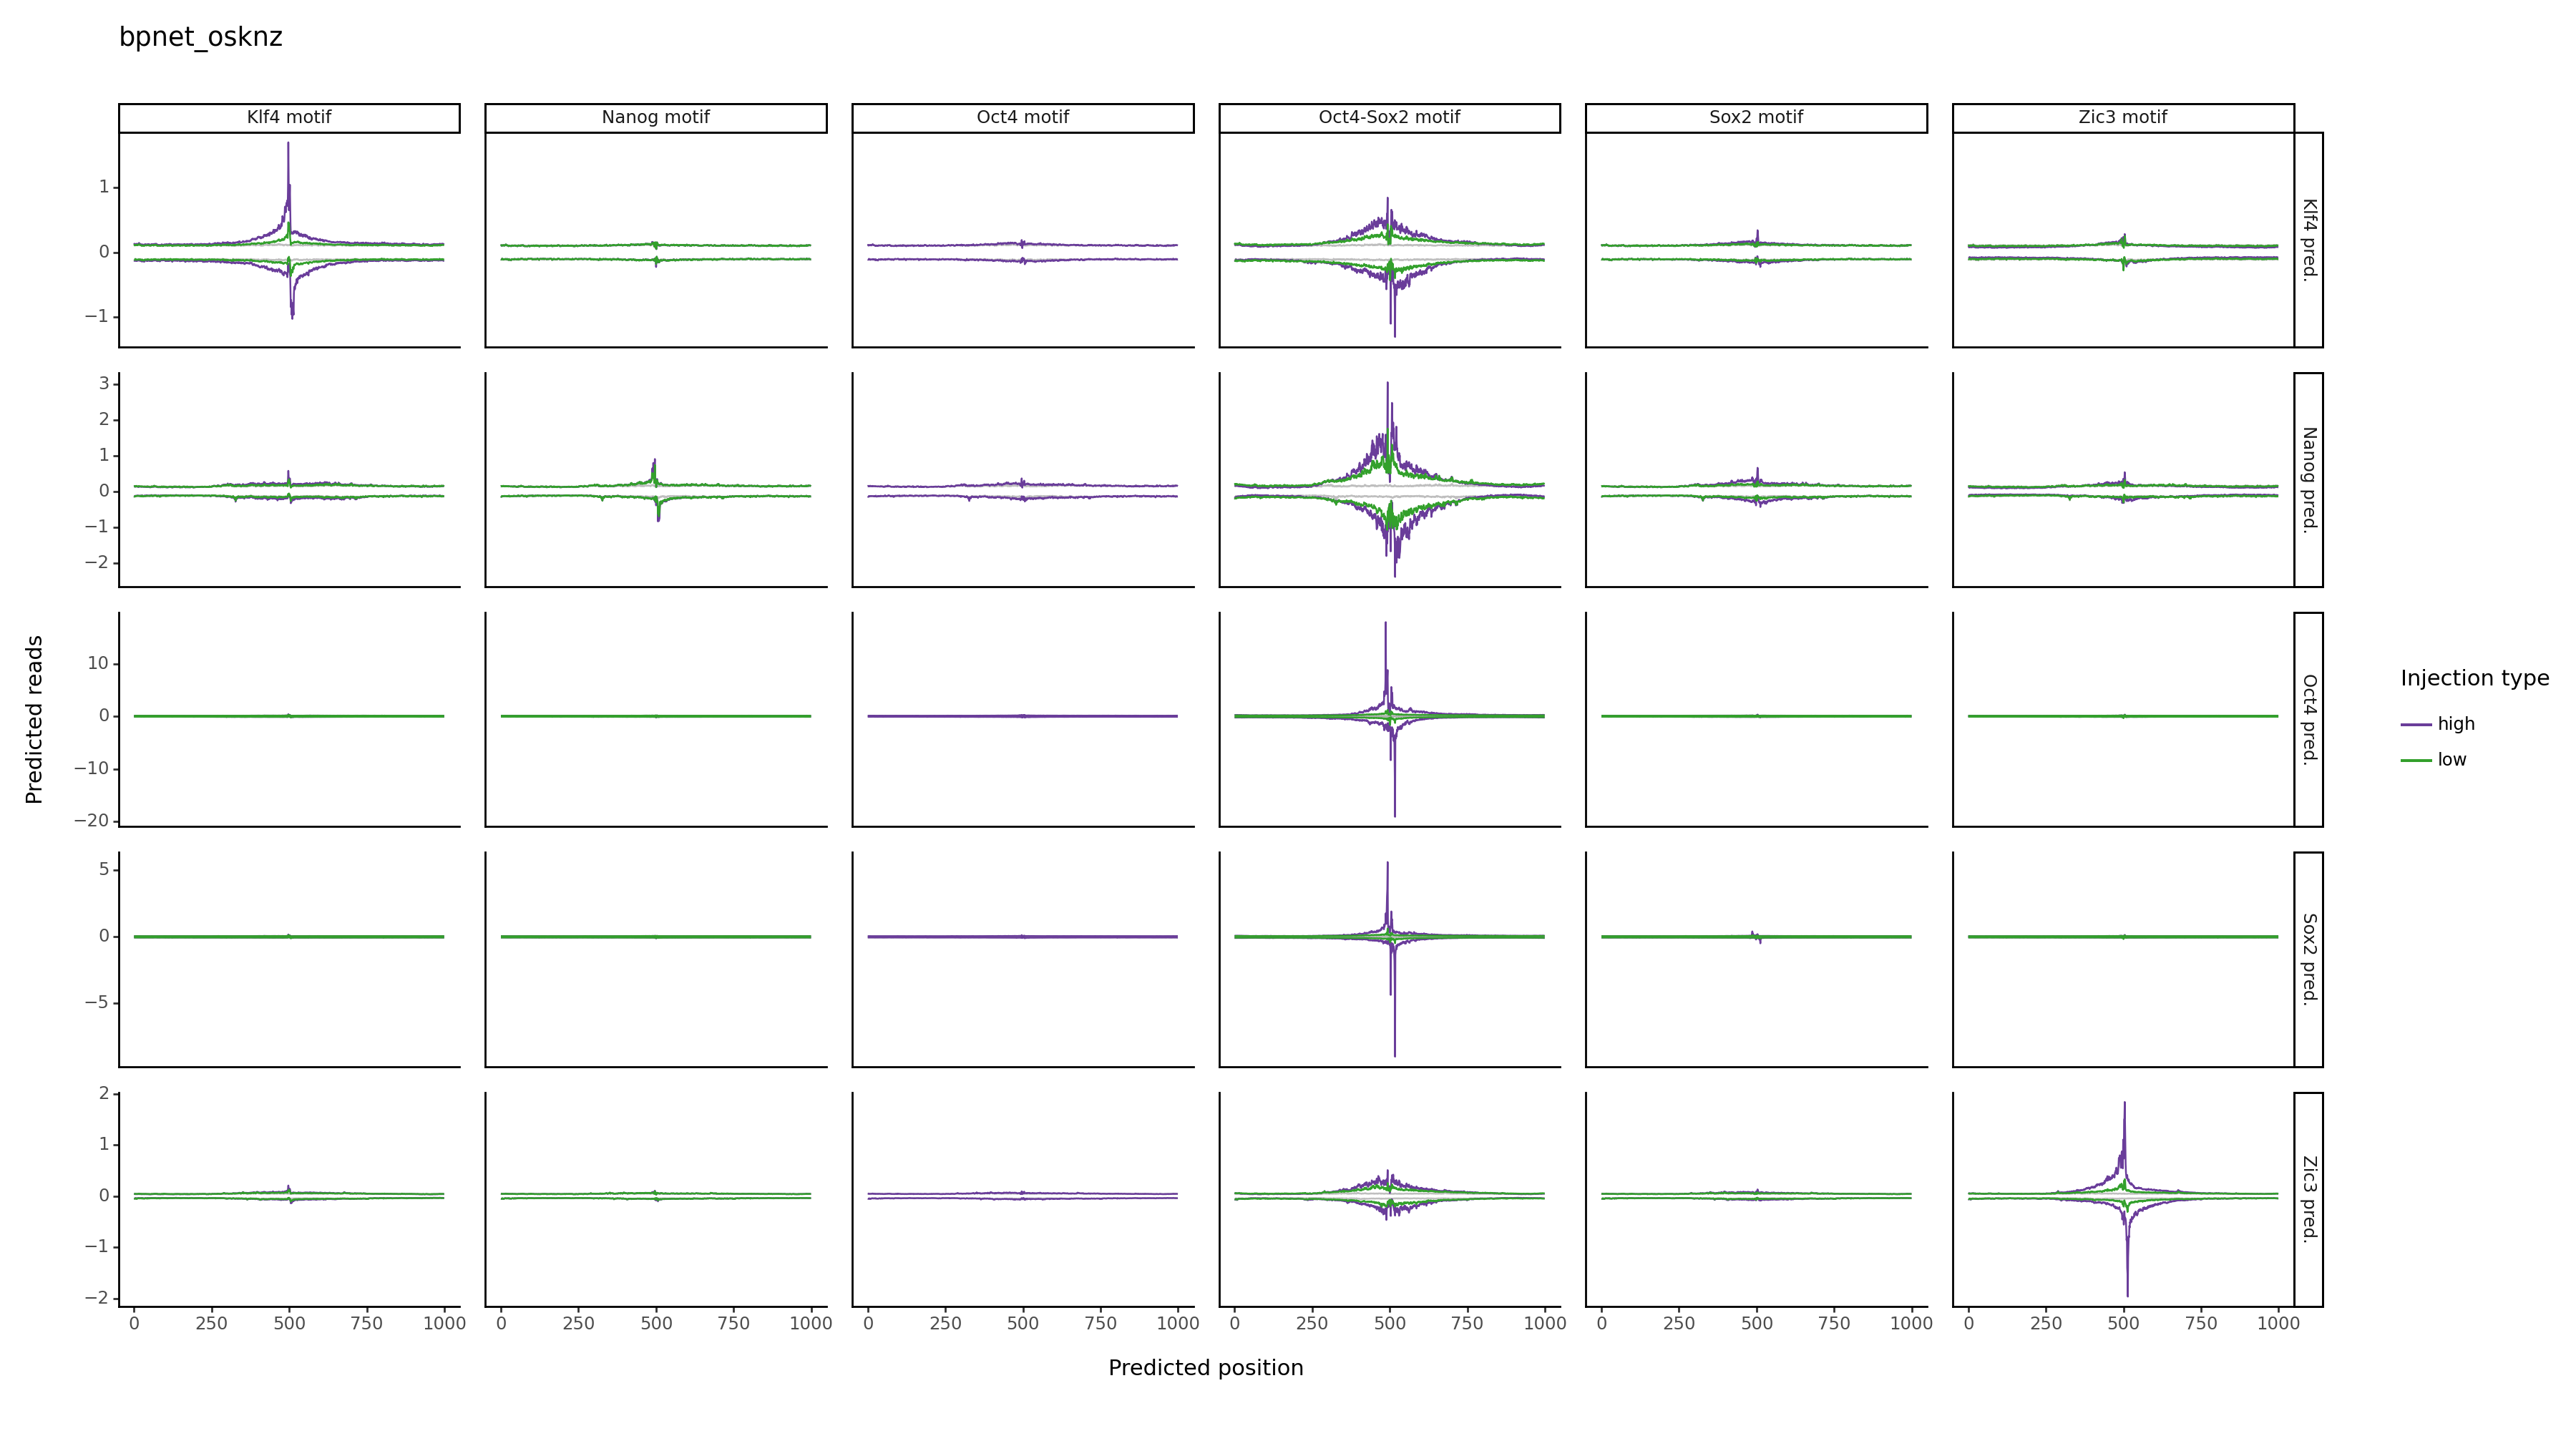

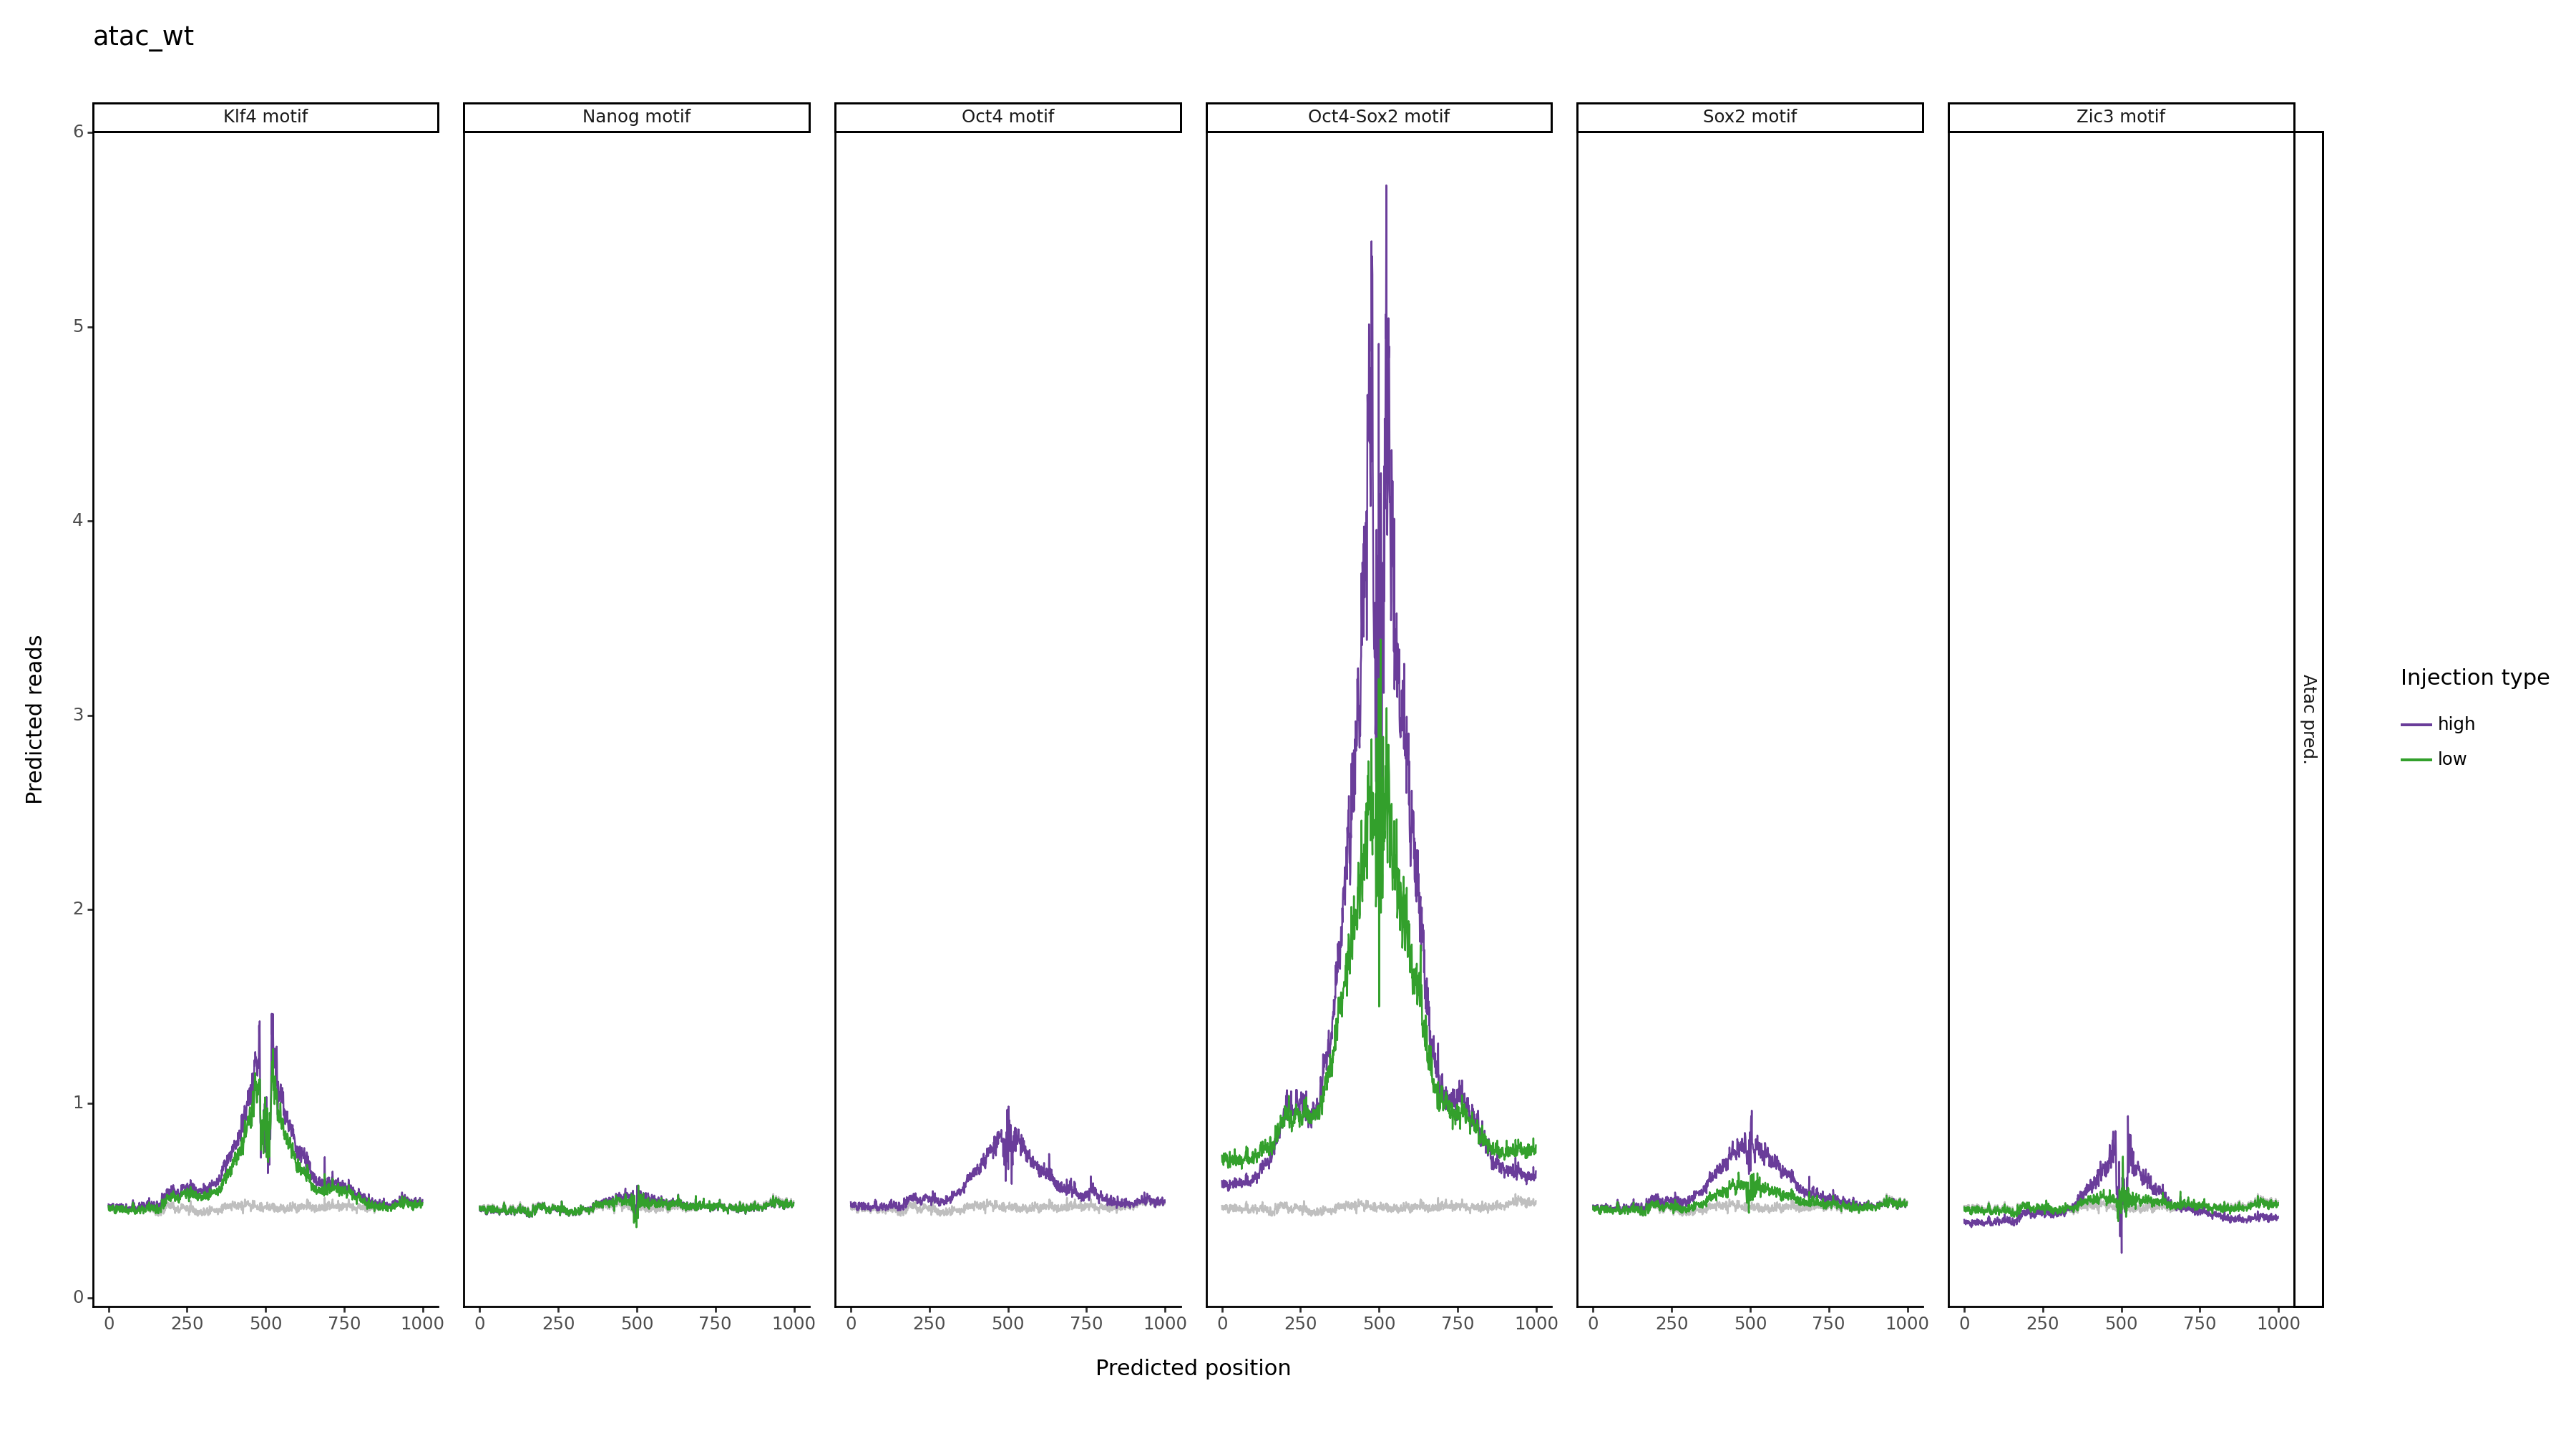

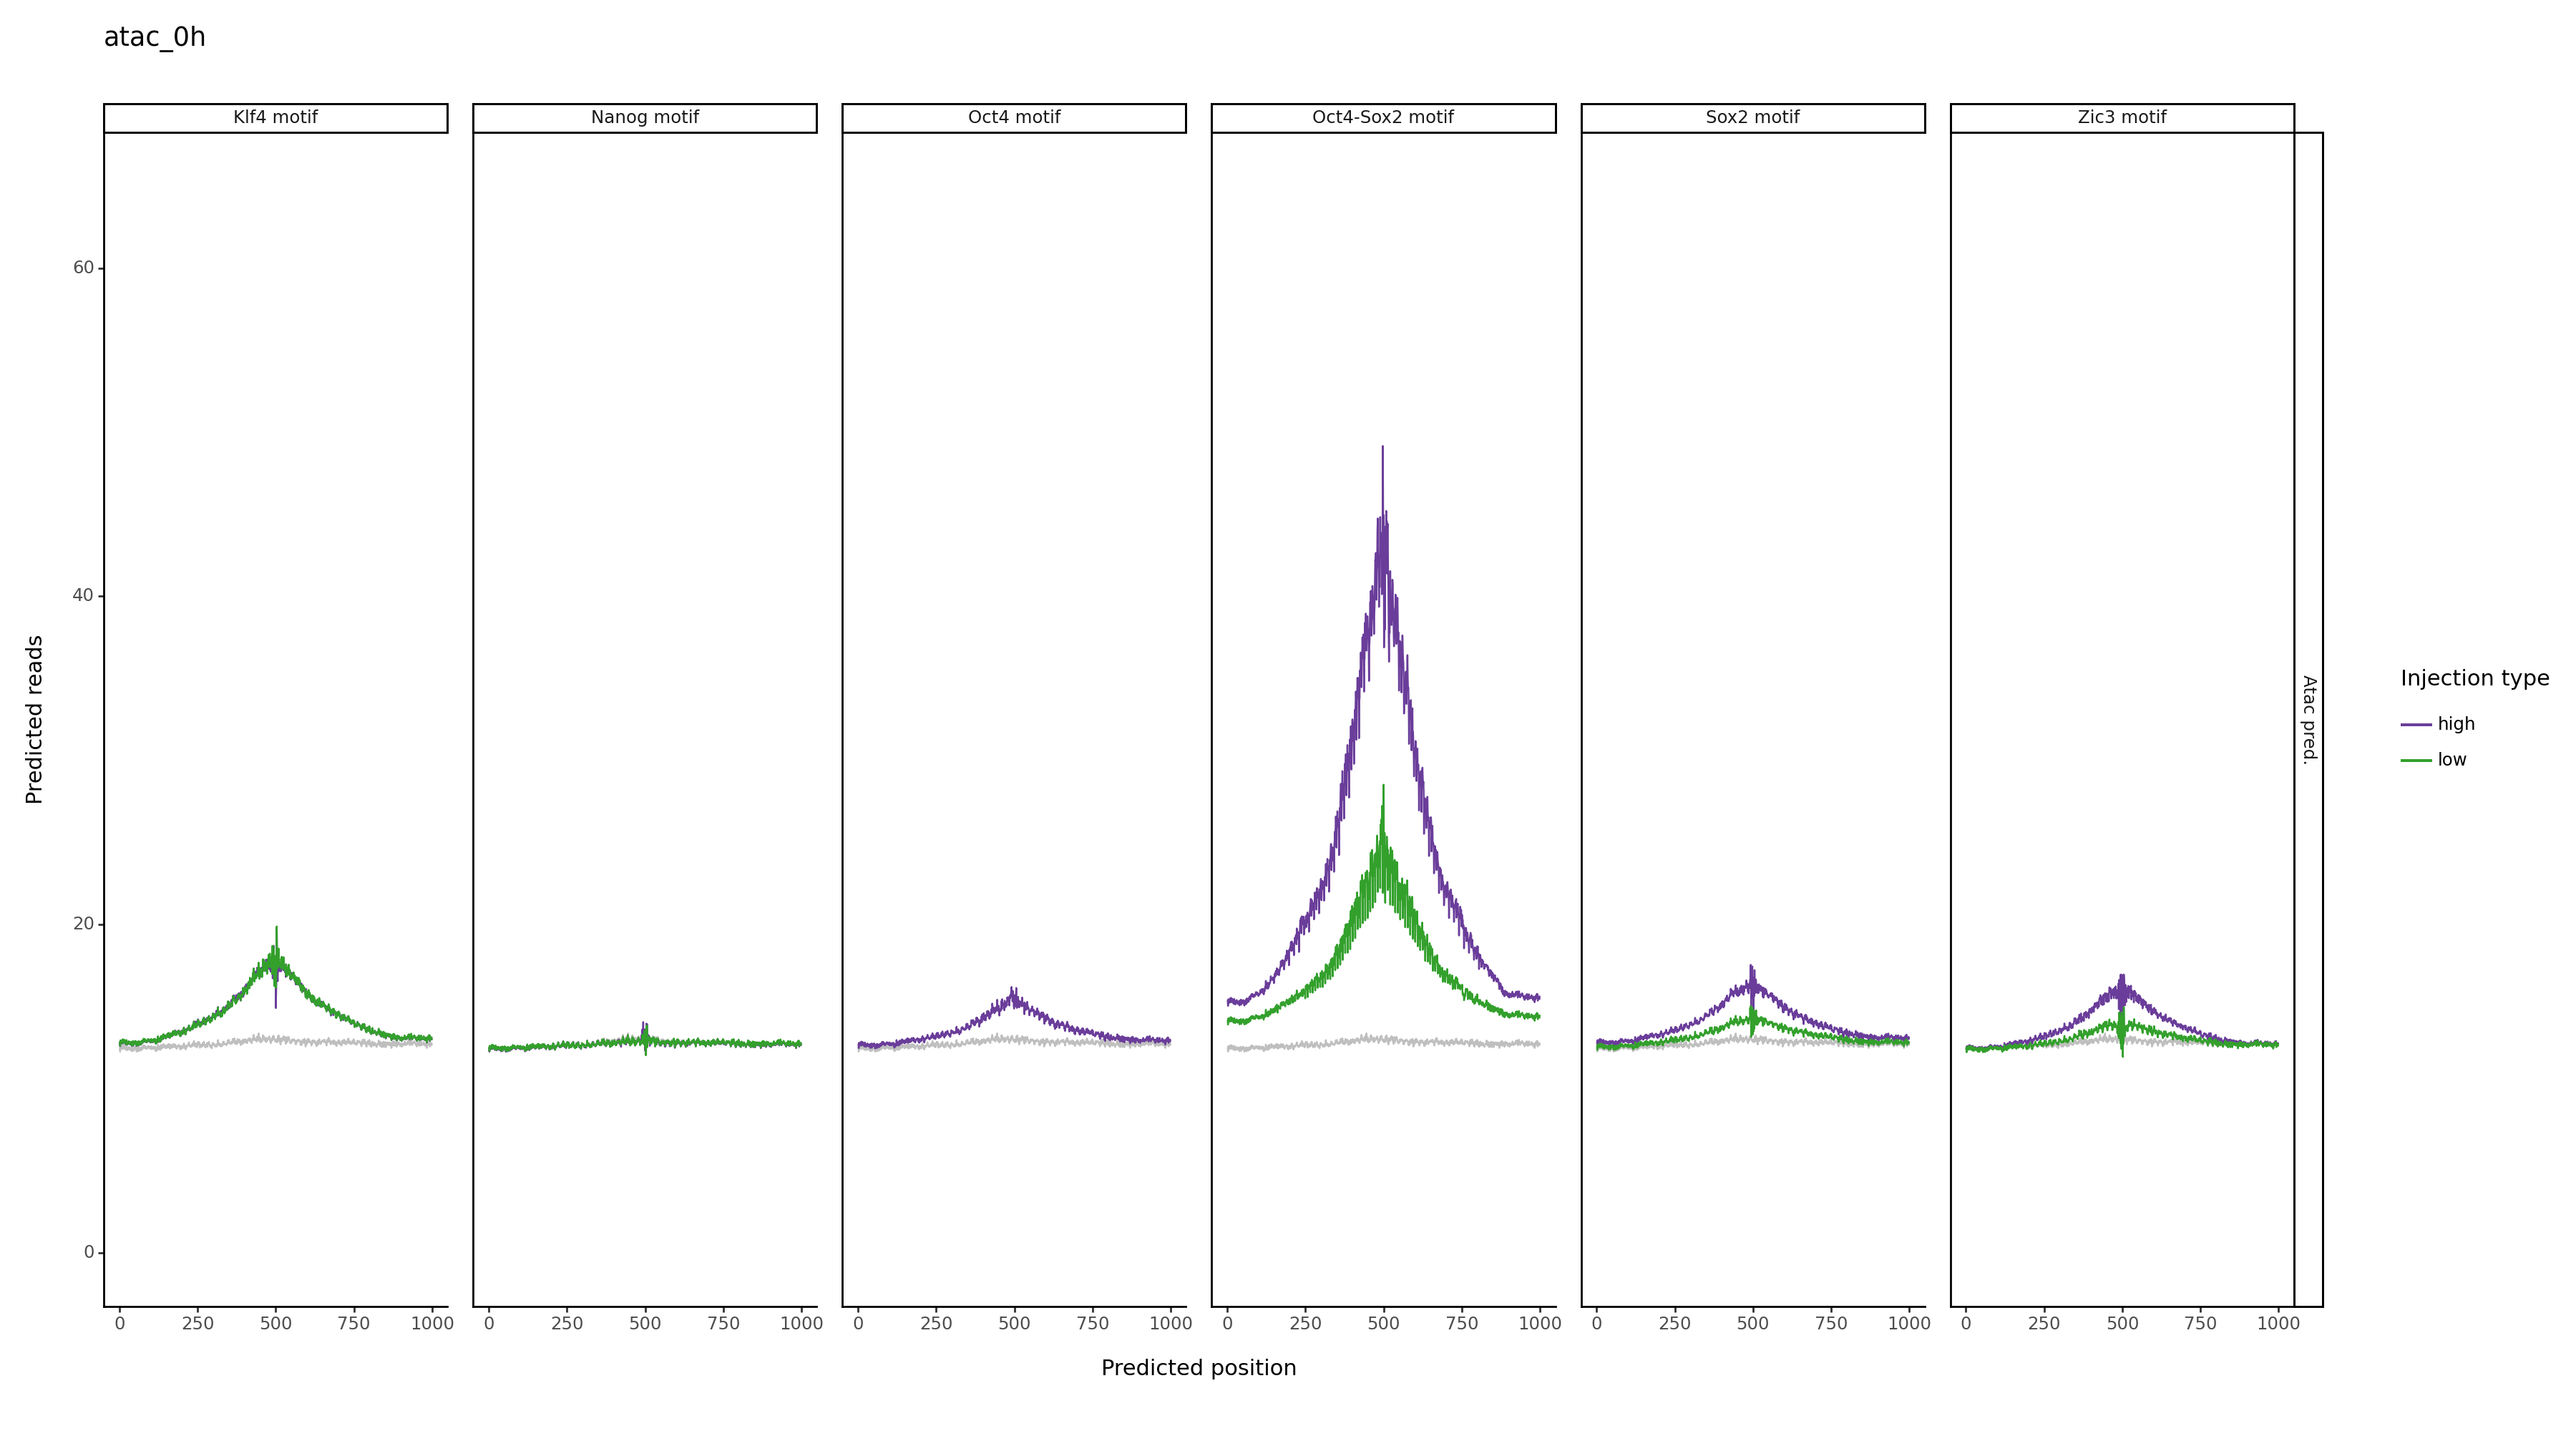

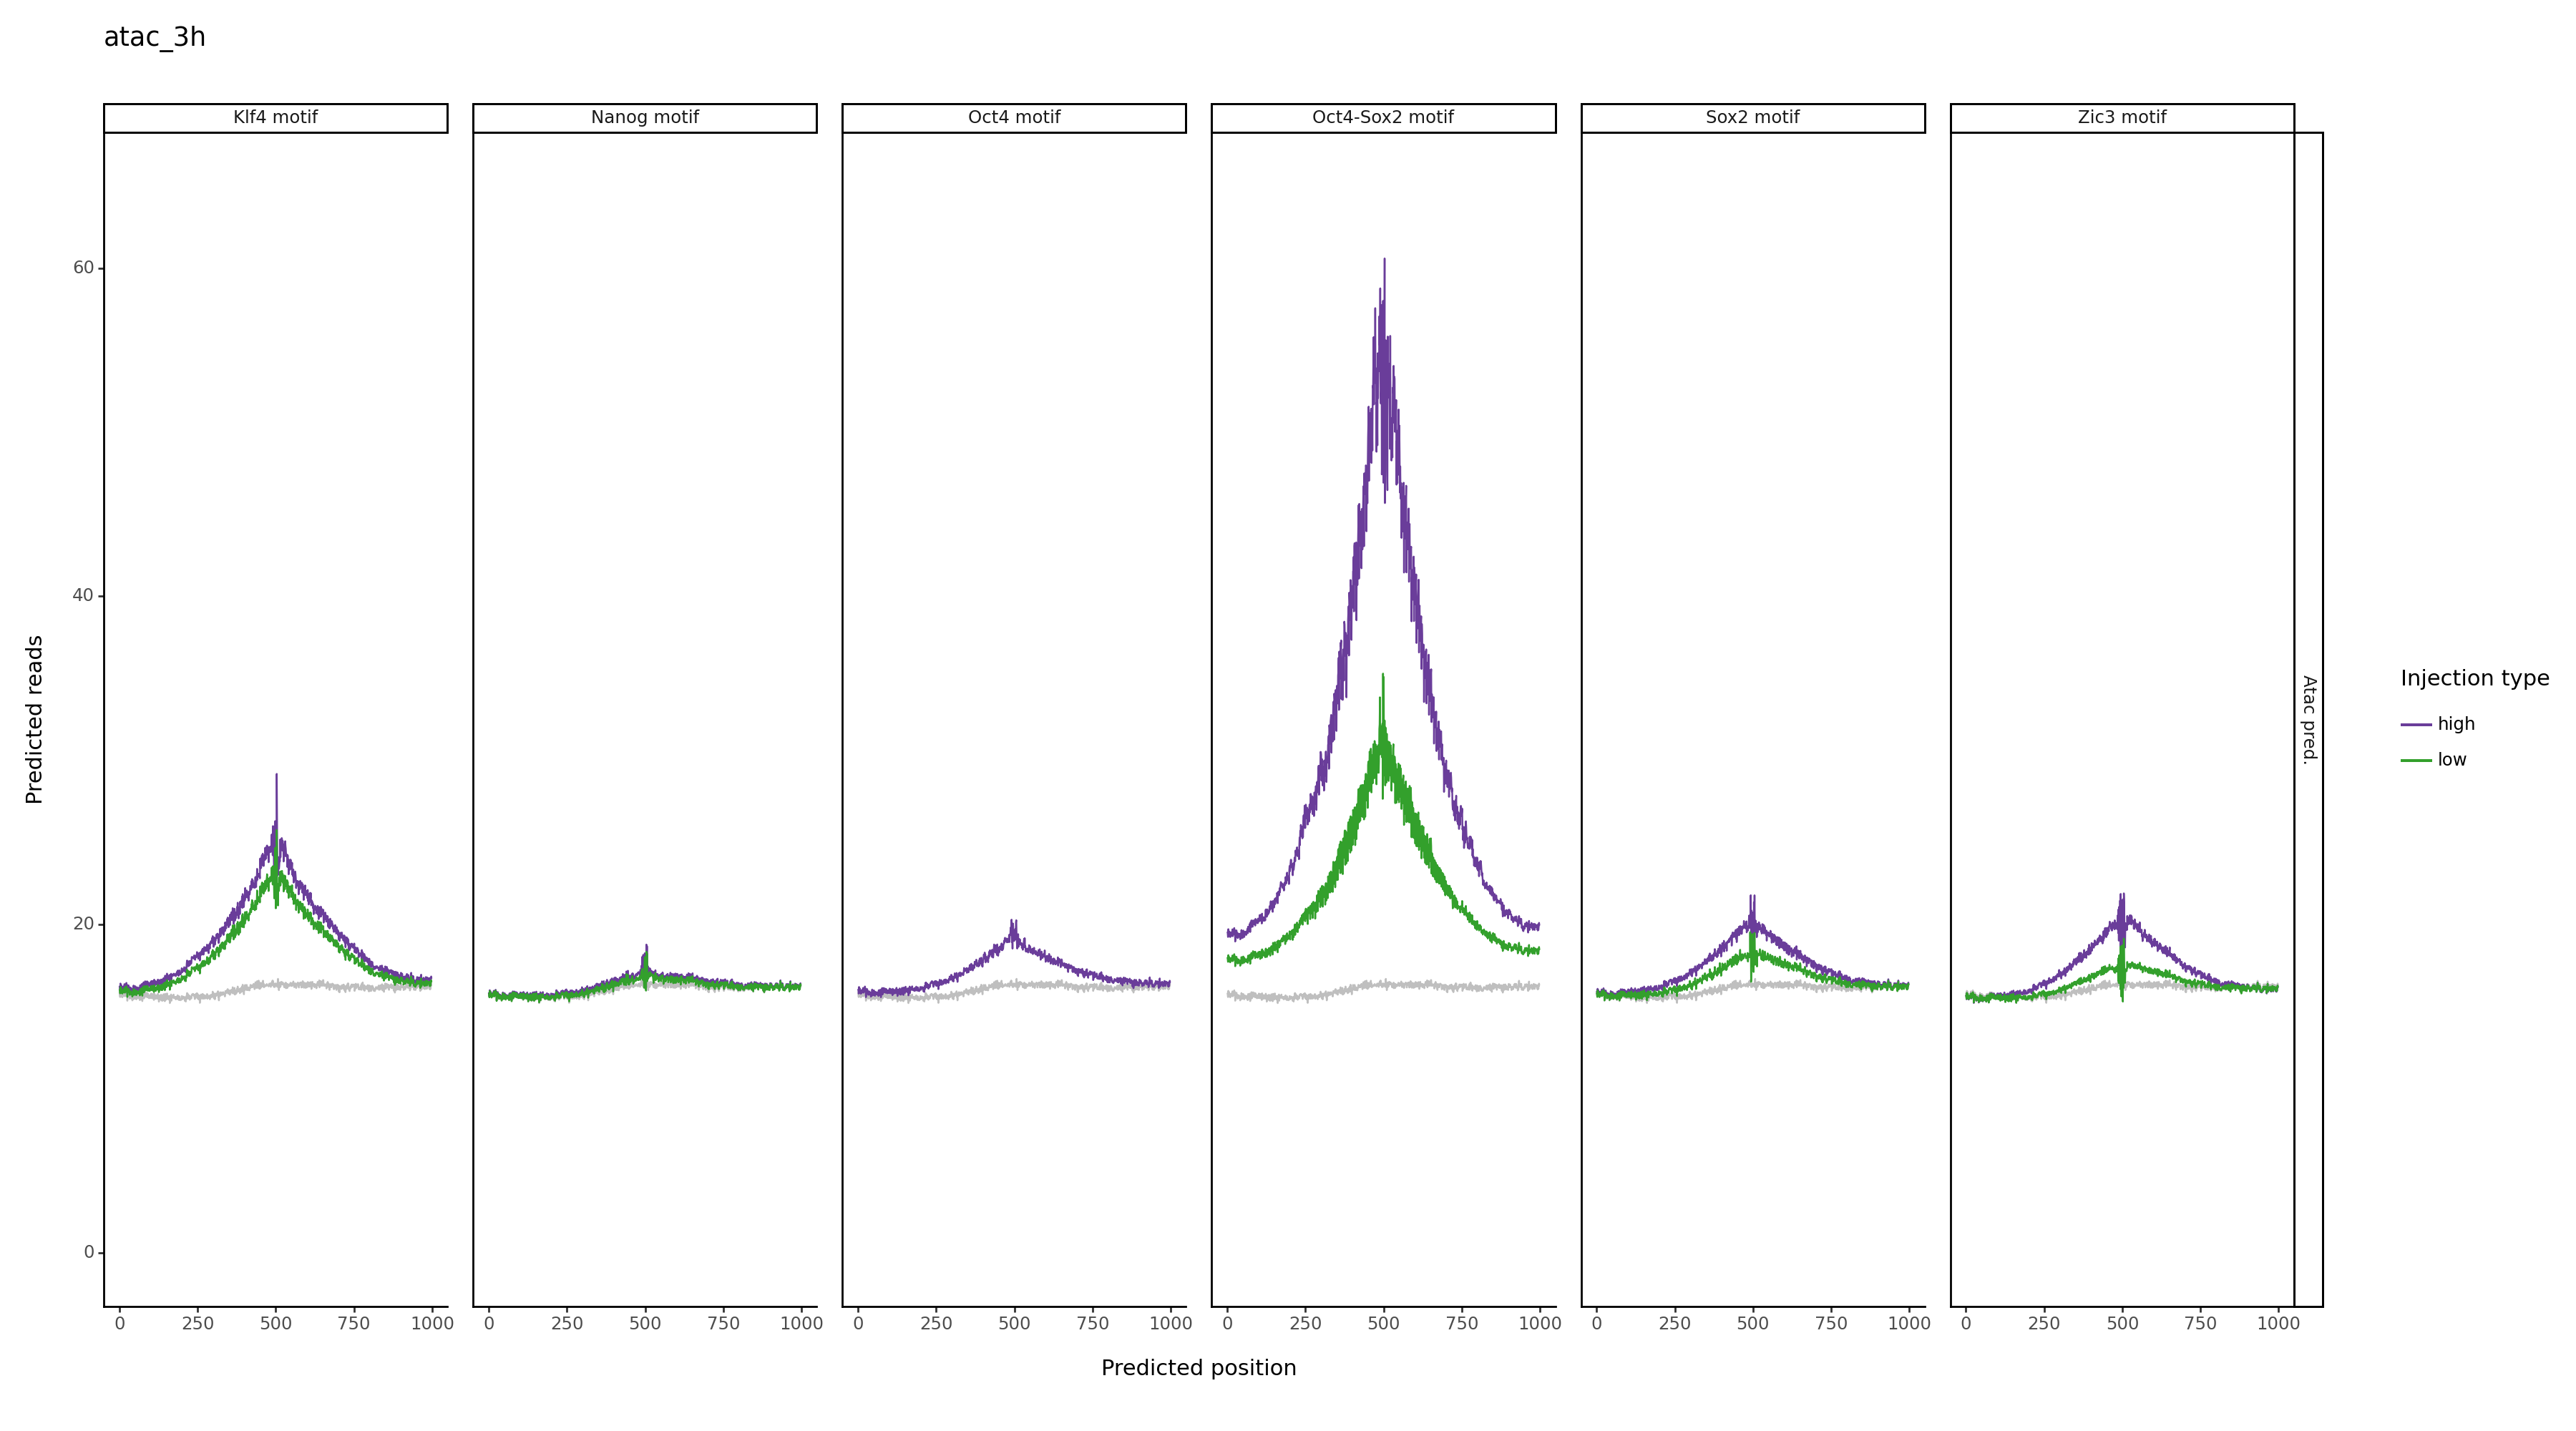

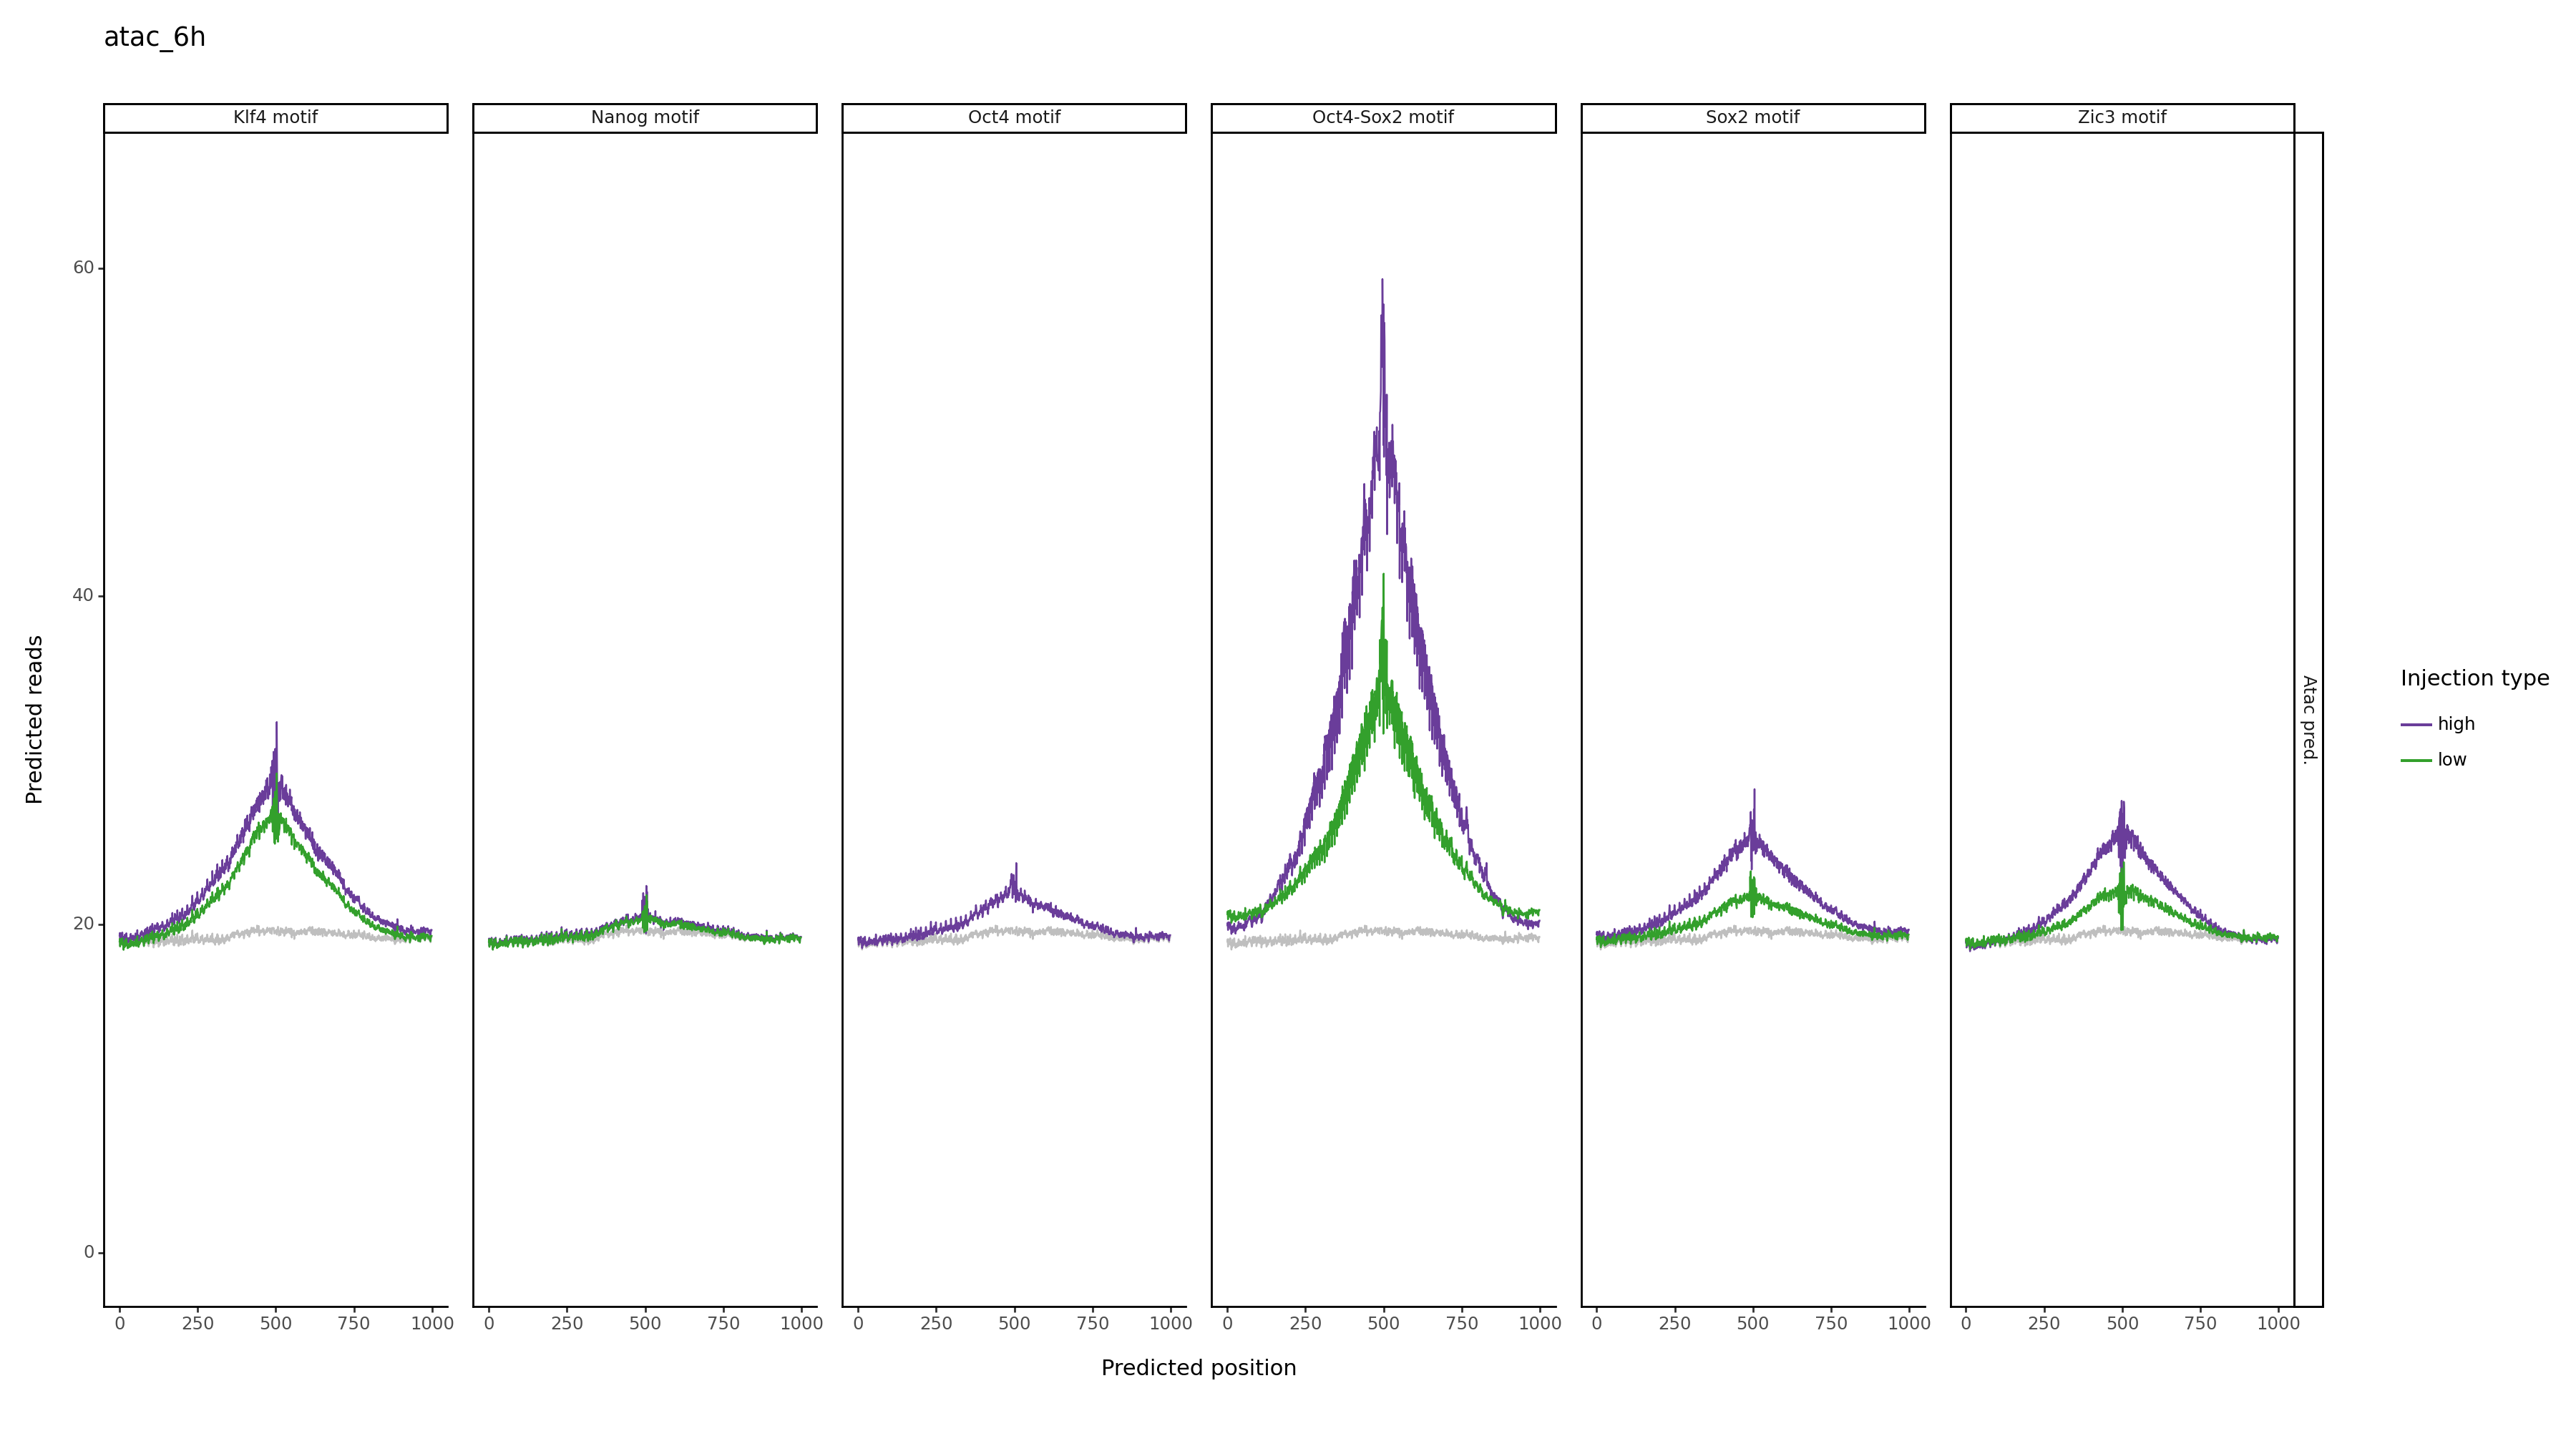

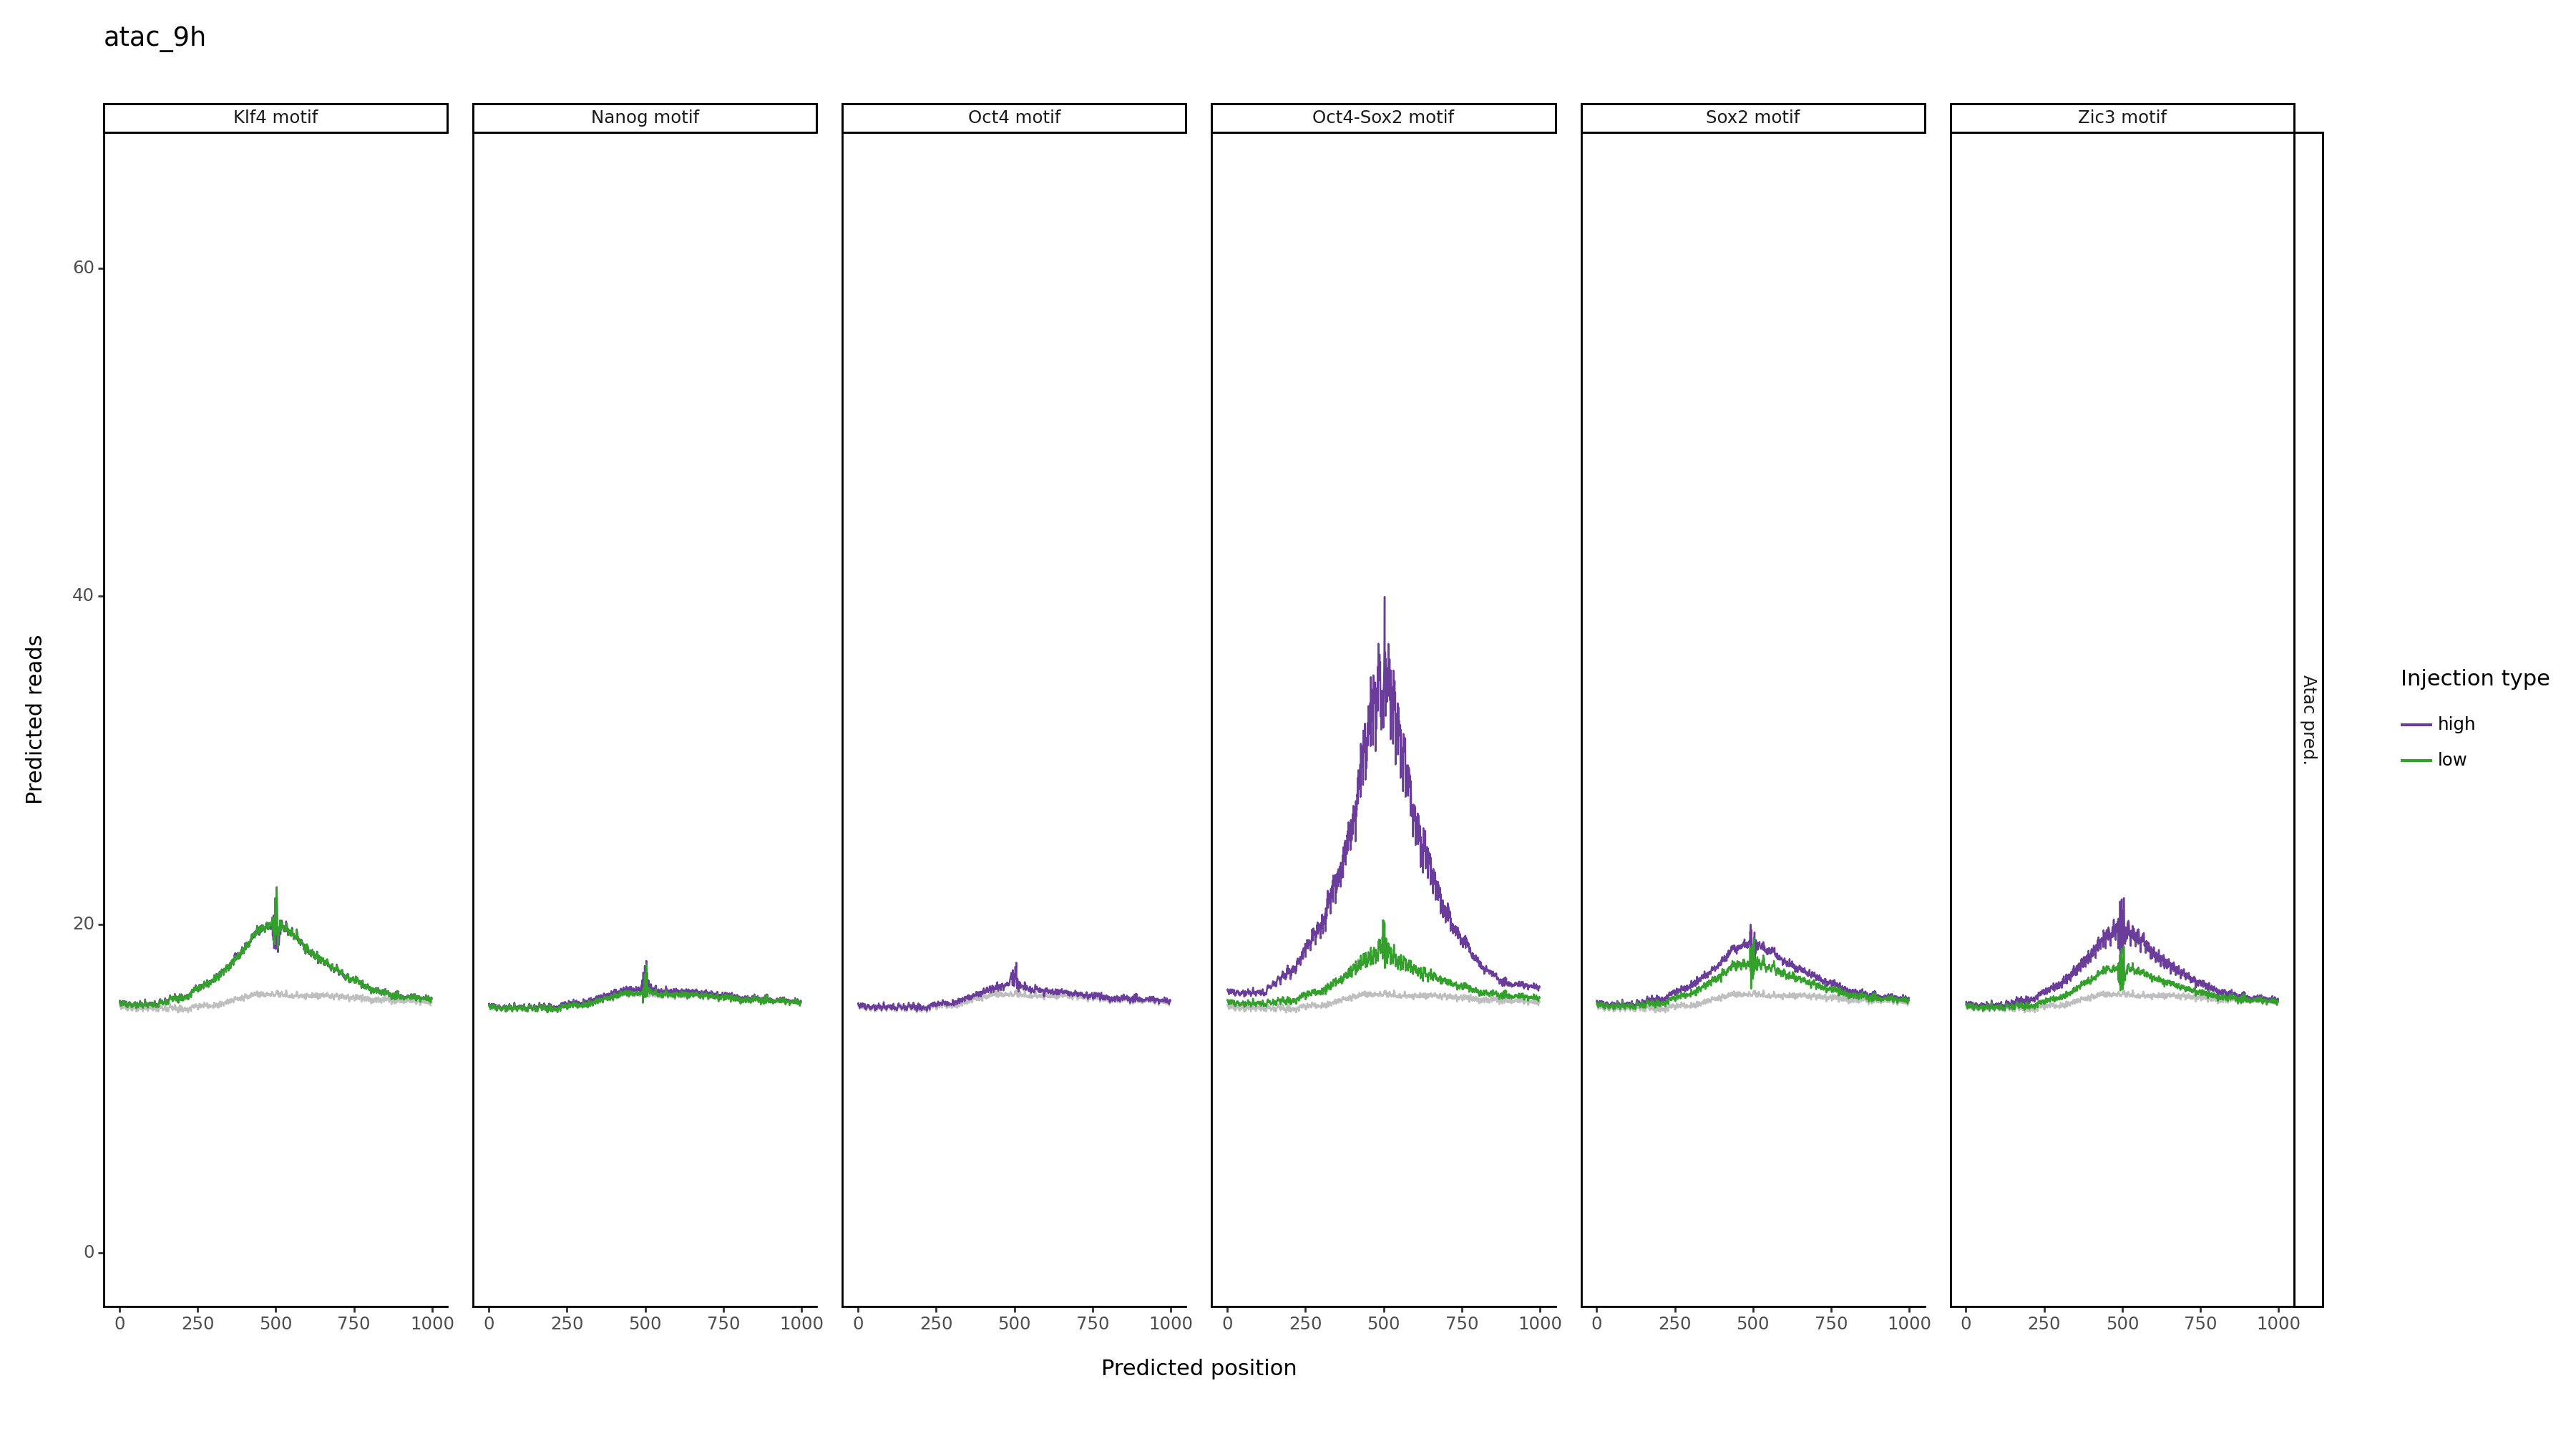

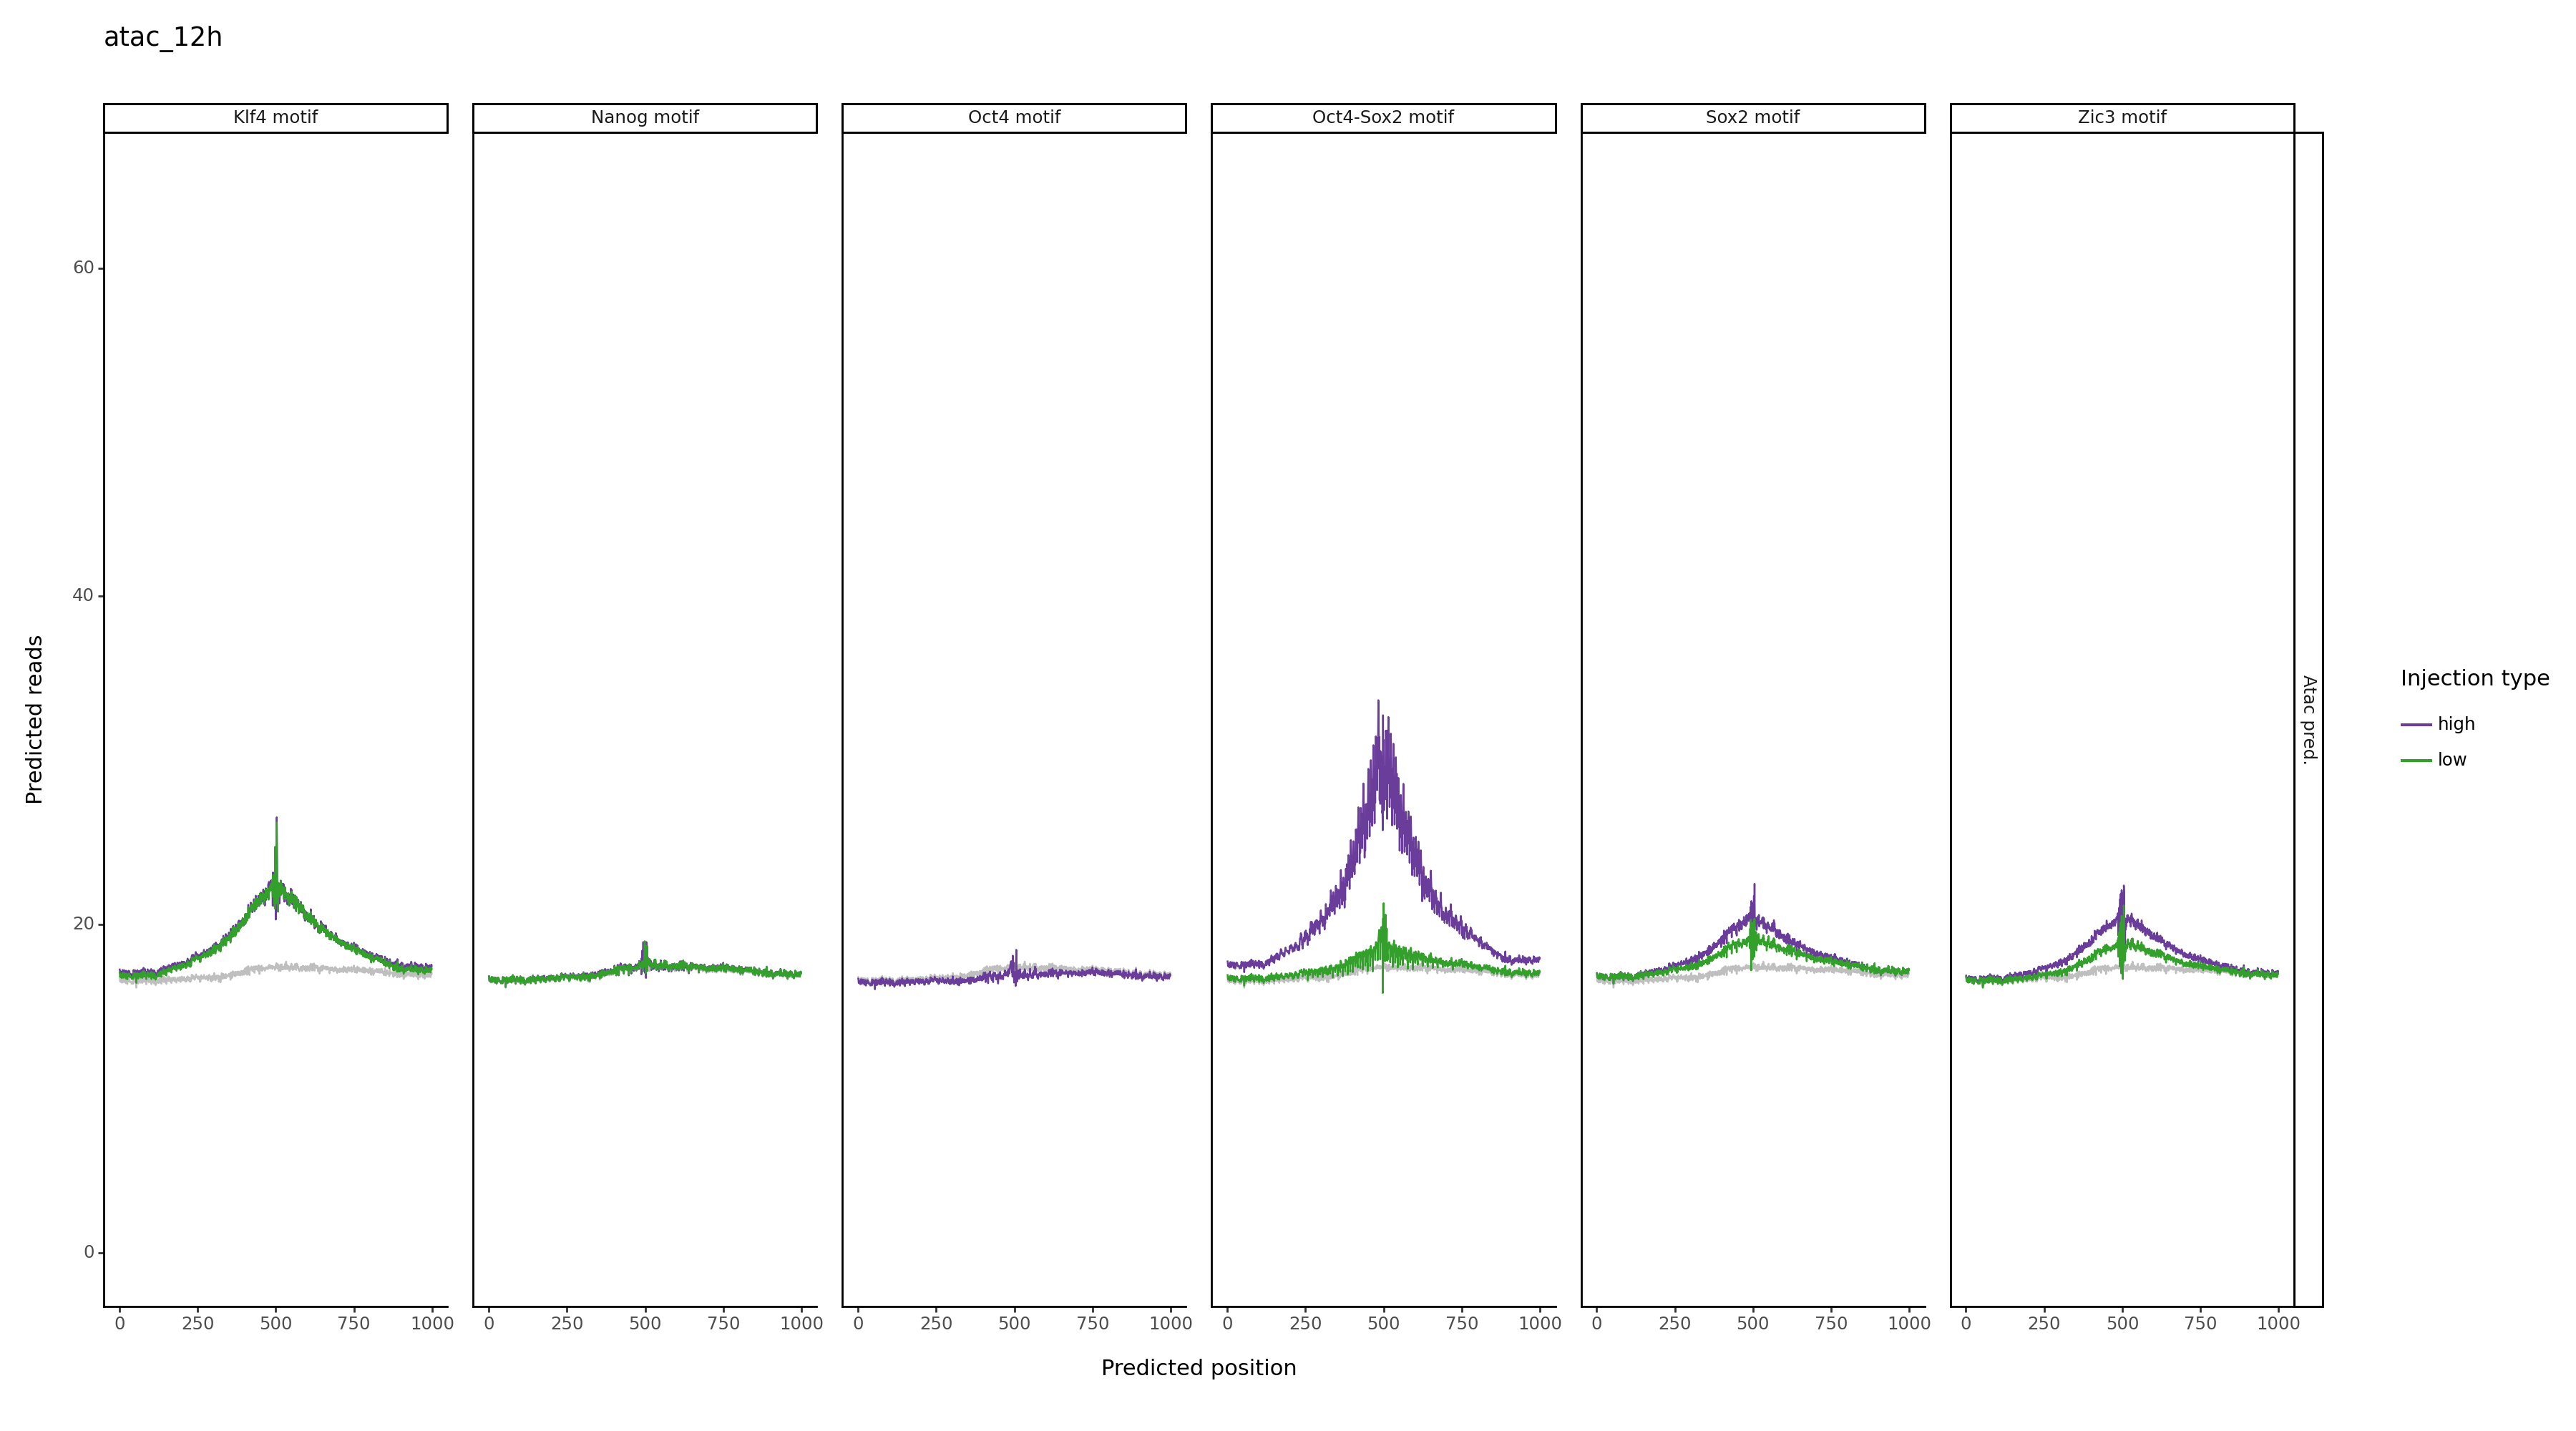

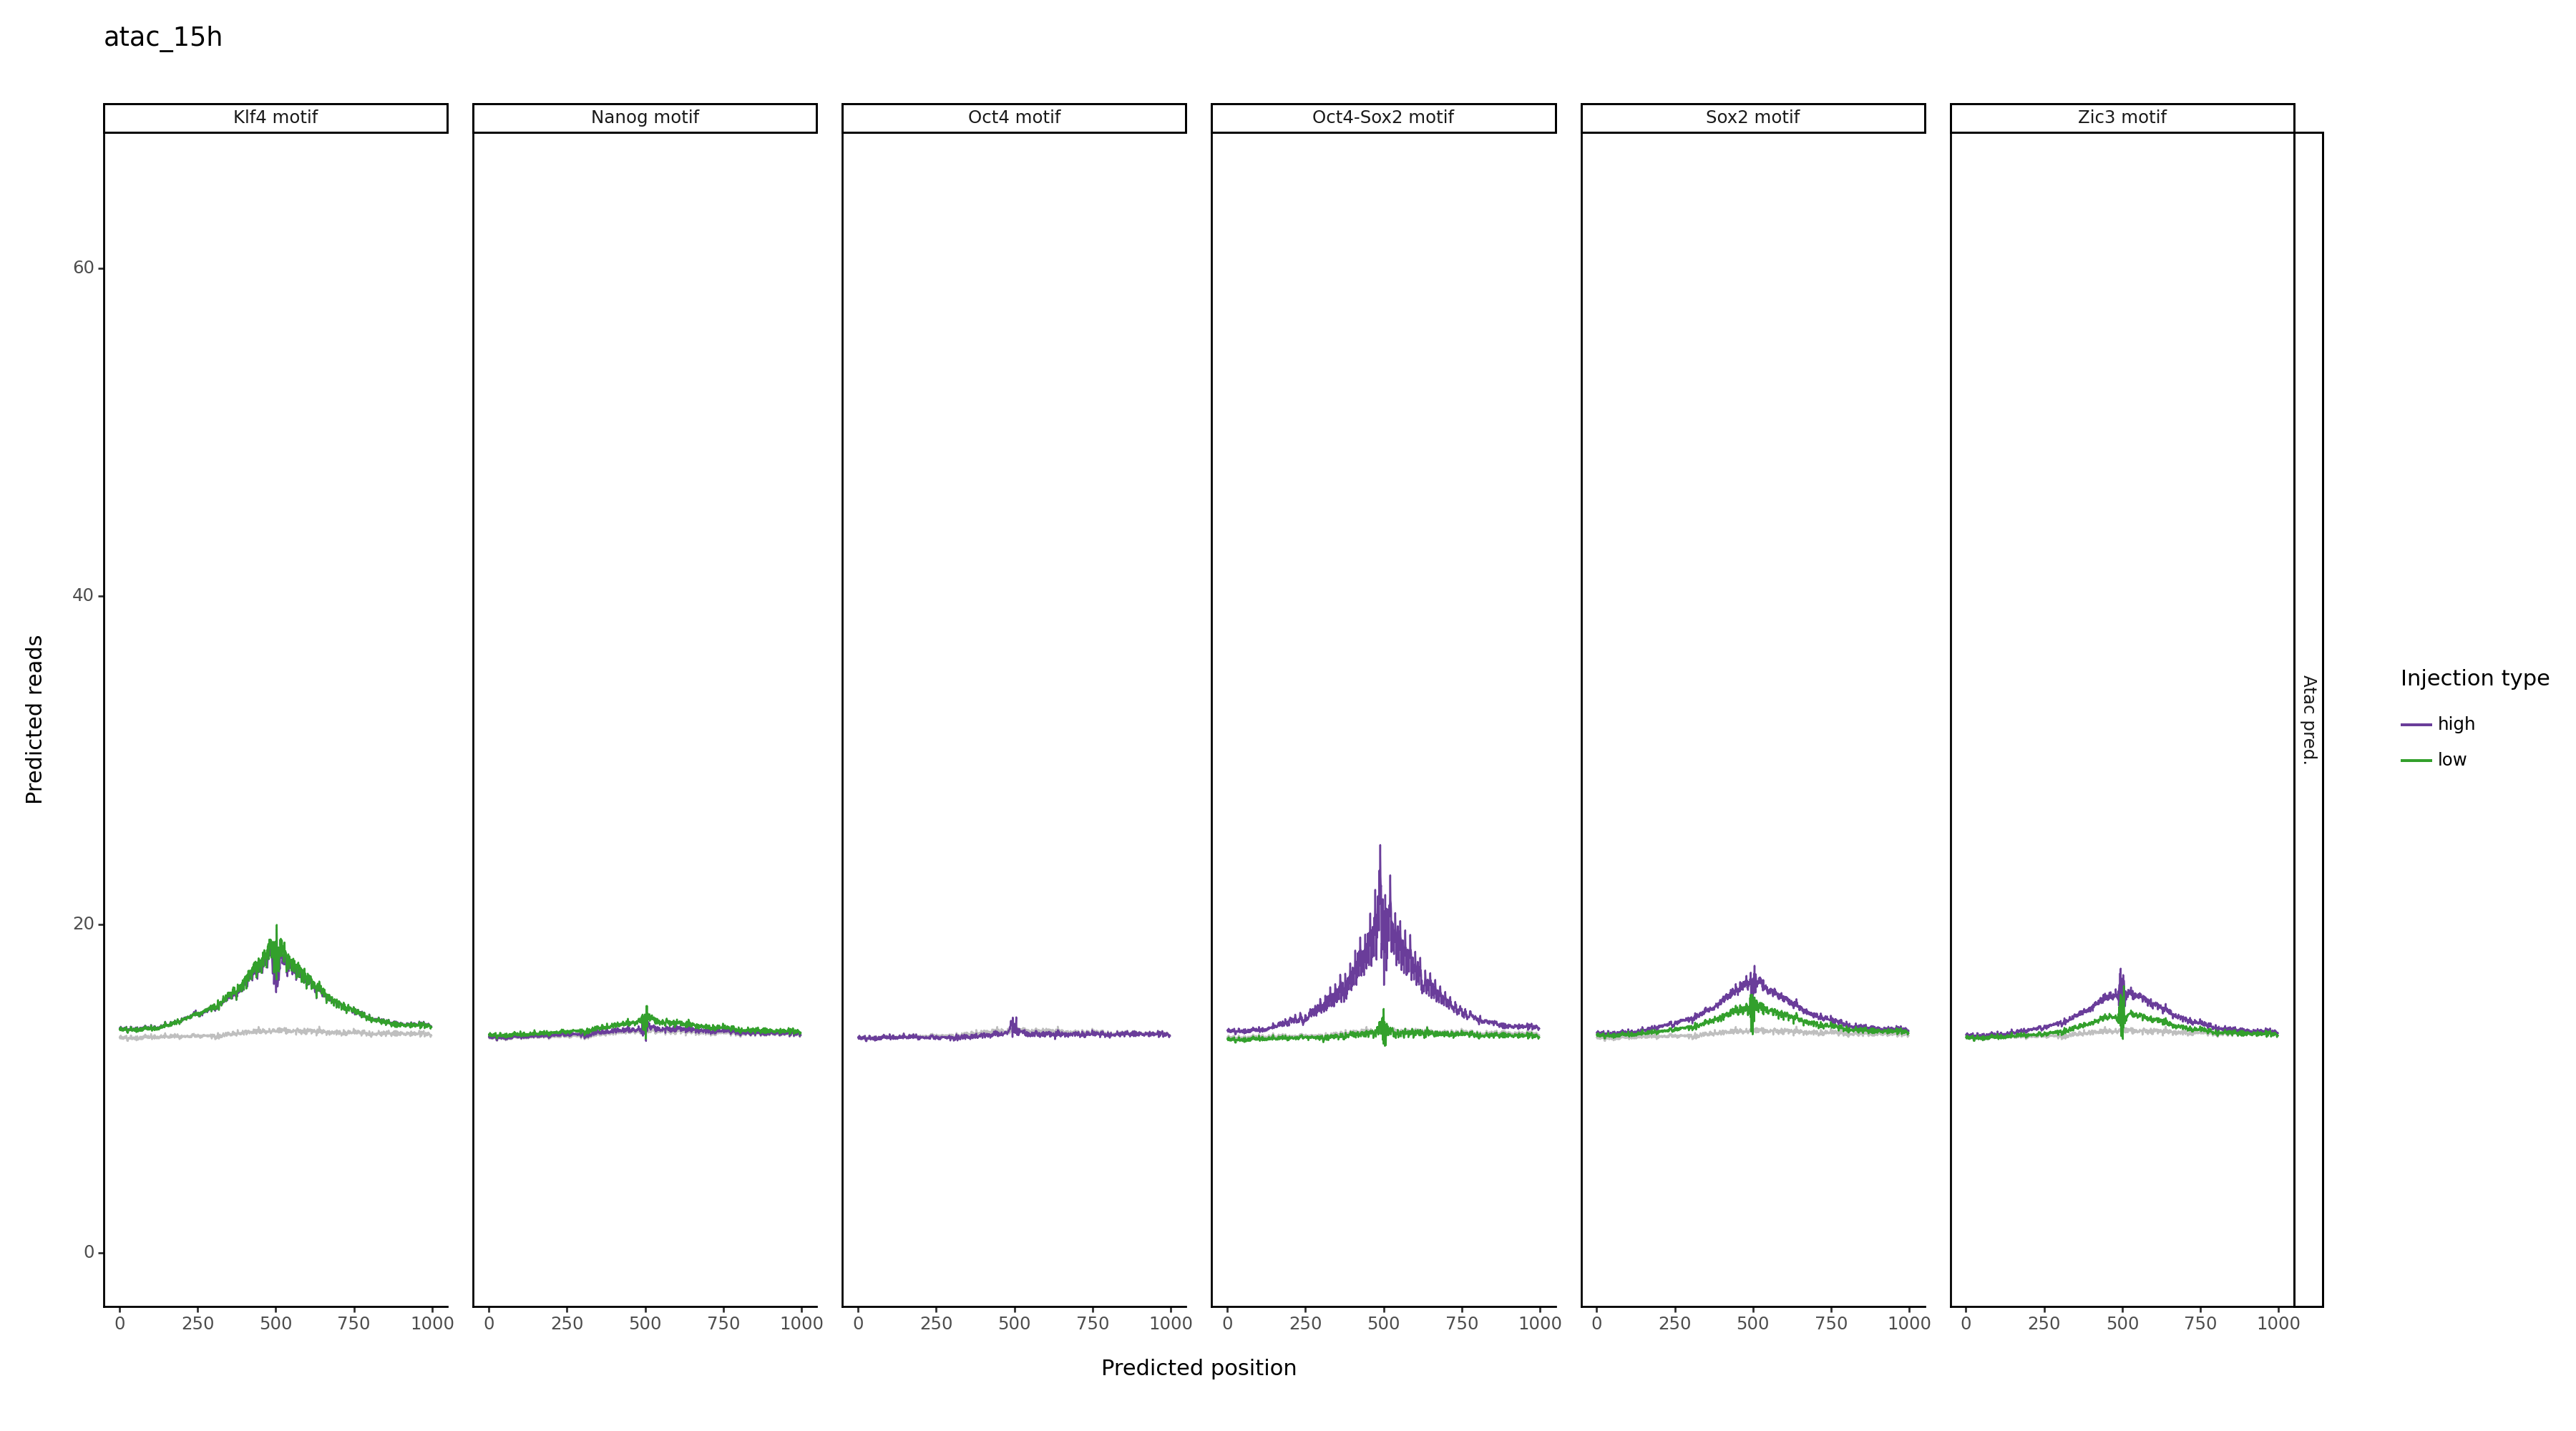

In [20]:
for model_name,model_info in modeling_design_dict.items():
    plotnine.options.figure_size = (18, 10)
    
    p_df = preds_df[preds_df['model_name']==model_name]
    showcase_injections_plot = (ggplot()+
        geom_line(data = p_df,
                  mapping = aes(x = 'position', y = 'stranded_null_pred', group = 'channel'), color = 'gray', alpha = .5)+
        geom_line(data = p_df,
                  mapping = aes(x = 'position', y = 'stranded_pred', color = 'affinity', group = 'label'))+
        scale_x_continuous(name = 'Predicted position')+
        scale_y_continuous(name = 'Predicted reads')+
        scale_color_manual(name = 'Injection type', values = ['#6a3d9a', '#33a02c', '#1f78b4'])+
        facet_grid('task ~ motif', scales = 'free_y')+
        ggtitle(model_name)+
        theme_classic())

    if 'h' in model_name: 
        showcase_injections_plot = (showcase_injections_plot + scale_y_continuous(name = 'Predicted reads', limits = (0, 65)))
        plotnine.options.figure_size = (18, 2.5)
    if 'atac' in model_name: 
        plotnine.options.figure_size = (18, 2.5)
    
    showcase_injections_plot.save(f'{figure_path}/showcase_affinity_injections_{model_name}.png')
    showcase_injections_plot.save(f'{figure_path}/showcase_affinity_injections_{model_name}.pdf')
    print(showcase_injections_plot)

# Predict median motifs

Load the model and show what the profiles look like across these sequences.

## Select median isolation scores(n=25)

For each motif, select central 25 sequences. 

In [21]:
motifs_df = pd.read_csv(motifs_path, sep = '\t')[['seq', 'motif']].drop_duplicates()
margs_w_motif_df = margs_df.merge(motifs_df, how='left')

In [22]:
#Find median values
med_margs_w_motif_df = margs_w_motif_df.groupby(['motif']).atac_wt_marg_x.median().reset_index()
med_margs_w_motif_df.columns = ['motif', 'median_atac_wt_marg']
margs_w_motif_df = margs_df.merge(med_margs_w_motif_df, how='left')
margs_w_motif_df['diff_from_med'] = np.abs(margs_w_motif_df['atac_wt_marg_x'] - margs_w_motif_df['median_atac_wt_marg'])

med_motifs_df = margs_w_motif_df.sort_values(['diff_from_med']).groupby('motif').head(n=25)
print(med_motifs_df.motif.value_counts())
med_motifs_df.head()

motif
Nanog        25
Oct4-Sox2    25
Zic3         25
Klf4         25
Sox2         25
Oct4         25
Name: count, dtype: int64


,seq,oct4_marg_x,oct4_inj,sox2_marg_x,sox2_inj,klf4_marg_x,klf4_inj,nanog_marg_x,nanog_inj,zic3_marg_x,zic3_inj,atac_wt_marg_x,atac_wt_inj,atac_wt_null,atac_0h_marg_x,atac_0h_inj,atac_0h_null,atac_3h_marg_x,atac_3h_inj,atac_3h_null,atac_6h_marg_x,atac_6h_inj,atac_6h_null,atac_9h_marg_x,atac_9h_inj,atac_9h_null,atac_12h_marg_x,atac_12h_inj,atac_12h_null,atac_15h_marg_x,atac_15h_inj,atac_15h_null,motif,oct4_marg_y,sox2_marg_y,klf4_marg_y,nanog_marg_y,zic3_marg_y,atac_wt_marg_y,atac_0h_marg_y,atac_3h_marg_y,atac_6h_marg_y,atac_9h_marg_y,atac_12h_marg_y,atac_15h_marg_y,median_atac_wt_marg,diff_from_med
35733,ACACTCAA,-0.012337,5.279080,-0.013431,4.600700,-0.019007,5.290336,0.016475,5.598894,-0.014854,4.371628,0.002112,6.027730,6.025618,-0.004854,9.415650,9.420504,0.000115,9.647718,9.647603,-0.000238,9.824507,9.824745,0.000615,9.600193,9.599578,0.002146,9.710053,9.707907,-0.004253,9.466751,9.471004,Nanog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002112,0.000000
1870,ATTTGAATAGGAATA,0.067114,5.358532,0.034009,4.648141,0.027974,5.337317,0.104597,5.687017,0.051699,4.438181,0.184890,6.210508,6.025618,0.074817,9.495321,9.420504,0.065776,9.713379,9.647603,0.022491,9.847236,9.824745,0.005213,9.604791,9.599578,0.001110,9.709017,9.707907,-0.012402,9.458602,9.471004,Oct4-Sox2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.184888,0.000002
17099,ATTTGCATCCCATTC,0.066401,5.357819,0.021604,4.635736,0.027925,5.337268,0.091831,5.674250,0.049945,4.436428,0.184885,6.210503,6.025618,0.053244,9.473748,9.420504,0.067846,9.715449,9.647603,0.038919,9.863664,9.824745,-0.009823,9.589755,9.599578,0.019199,9.727106,9.707907,-0.008286,9.462718,9.471004,Oct4-Sox2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.184888,0.000002
32045,TTGCAGTAGGG,0.002650,5.294067,-0.001881,4.612250,0.007839,5.317182,-0.011698,5.570721,0.046964,4.433446,0.030744,6.056362,6.025618,0.010290,9.430794,9.420504,0.017629,9.665232,9.647603,0.011037,9.835782,9.824745,0.011720,9.611298,9.599578,0.006773,9.714680,9.707907,0.007557,9.478561,9.471004,Zic3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030741,0.000003
33953,TTTCAGCGGGA,0.000100,5.291518,-0.001406,4.612725,0.002055,5.311398,-0.000477,5.581943,0.082627,4.469110,0.030738,6.056355,6.025618,0.037552,9.458056,9.420504,0.032884,9.680487,9.647603,0.027404,9.852149,9.824745,0.029655,9.629233,9.599578,0.022934,9.730841,9.707907,0.021664,9.492668,9.471004,Zic3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030741,0.000003


## Predict median marginalized profiles

In [23]:
preds_df = pd.DataFrame()
for model_name,model_info in tqdm(modeling_design_dict.items()):
    K.clear_session()
    model = load_model(model_info['model_dir'], custom_objects = {'multinomialNll' : losses.multinomialNll, 'reweightableMse': losses.dummyMse})
    null_seqs = np.load(random_seqs_path)['seqs_1he']
    tasks = model_info['tasks']

    #Predict null binding
    null_preds_raw_arr = model.predict(null_seqs, verbose = False)
    
    null_preds_avg_df = pd.DataFrame()
    for i,task in tqdm(enumerate(tasks)):
        
        #Convert logits and logcounts to human-readable ChIP-nexus profile with counts
        profile_by_task = []
        for j in range(trials):
            profile = logitsToProfile(logitsAcrossSingleRegion = null_preds_raw_arr[i][j], 
                                      logCountsAcrossSingleRegion = null_preds_raw_arr[i + len(tasks)][j])
            profile_by_task.append(profile)
        
        #Average across trials
        null_pred_avg_arr = np.mean(np.array(profile_by_task), axis = 0)
        
        #Convert to tidy pd.df
        null_pred_avg_df = pd.DataFrame(null_pred_avg_arr, columns = list(range(model_info['num-channels'])))
        null_pred_avg_df['position'] = list(range(null_pred_avg_df.shape[0]))
        null_pred_avg_df = null_pred_avg_df.melt(id_vars = 'position', var_name = 'channel', value_name = 'null_pred')
        null_pred_avg_df['task'] = task
        null_preds_avg_df = pd.concat([null_preds_avg_df, null_pred_avg_df])

    #Predict injected binding for marginalizations
    injected_preds_df = pd.DataFrame()
    for i,row in med_motifs_df.iterrows():
        
        #Inject motif into null sequences
        injected_seqs = []
        for k in range(trials):
            injected_seq = insert_motif(seq = one_hot_decode_sequence(null_seqs[k]), 
                                        motif = row.seq, 
                                        position = input_length//2)
            injected_seqs.append(injected_seq)
        injected_seqs_1he = one_hot_encode_sequences(injected_seqs)
        
        #Predict injected sequences
        injected_preds_raw_arr = model.predict(injected_seqs_1he, verbose = False)
        
        #Process injected predictions to tidy pd.df
        injected_preds_avg_df = pd.DataFrame()
        for k,task in enumerate(tasks):
    
            #Convert logits and logcounts to human-readable ChIP-nexus profile with counts
            profile_by_task = []
            for j in range(trials):
                profile = logitsToProfile(logitsAcrossSingleRegion = injected_preds_raw_arr[k][j], 
                                          logCountsAcrossSingleRegion = injected_preds_raw_arr[k + len(tasks)][j])
                profile_by_task.append(profile)
    
            #Average across trials
            injected_pred_avg_arr = np.mean(np.array(profile_by_task), axis = 0)
    
            #Convert to tidy pd.df
            injected_pred_avg_df = pd.DataFrame(injected_pred_avg_arr, columns = list(range(model_info['num-channels'])))
            injected_pred_avg_df['position'] = list(range(injected_pred_avg_df.shape[0]))
            injected_pred_avg_df = injected_pred_avg_df.melt(id_vars = 'position', var_name = 'channel', value_name = 'pred')
            injected_pred_avg_df['task'] = task
            injected_preds_avg_df = pd.concat([injected_preds_avg_df, injected_pred_avg_df]) 
            
        injected_preds_avg_df['motif'] = row.motif
        injected_preds_avg_df['seq'] = row.seq
        
        injected_preds_df = pd.concat([injected_preds_df, injected_preds_avg_df])
    injected_preds_df['model_name'] = model_name
    injected_preds_df = injected_preds_df.merge(null_preds_avg_df, how = 'left', on = ['position', 'channel', 'task'])
    preds_df = pd.concat([preds_df, injected_preds_df])
preds_df.head(n=10)

  0%|                                                | 0/8 [00:00<?, ?it/s]
5it [00:00, 112.47it/s]
 12%|████▉                                  | 1/8 [05:10<36:10, 310.07s/it]
1it [00:00, 133.33it/s]
 25%|█████████▊                             | 2/8 [09:49<29:12, 292.11s/it]
1it [00:00, 122.49it/s]
 38%|██████████████▋                        | 3/8 [14:29<23:52, 286.42s/it]
1it [00:00, 96.90it/s]
 50%|███████████████████▌                   | 4/8 [19:08<18:53, 283.46s/it]
1it [00:00, 118.02it/s]
 62%|████████████████████████▍              | 5/8 [23:48<14:07, 282.39s/it]
1it [00:00, 94.94it/s]
 75%|█████████████████████████████▎         | 6/8 [28:26<09:21, 280.87s/it]
1it [00:00, 122.79it/s]
 88%|██████████████████████████████████▏    | 7/8 [33:03<04:39, 279.69s/it]
1it [00:00, 115.92it/s]
100%|███████████████████████████████████████| 8/8 [37:44<00:00, 283.00s/it]


,position,channel,pred,task,motif,seq,model_name,null_pred
0,0,0,0.094288,oct4,Nanog,ACACTCAA,bpnet_osknz,0.095631
1,1,0,0.099370,oct4,Nanog,ACACTCAA,bpnet_osknz,0.100604
2,2,0,0.094670,oct4,Nanog,ACACTCAA,bpnet_osknz,0.095956
3,3,0,0.099983,oct4,Nanog,ACACTCAA,bpnet_osknz,0.101353
4,4,0,0.101306,oct4,Nanog,ACACTCAA,bpnet_osknz,0.102985
5,5,0,0.102428,oct4,Nanog,ACACTCAA,bpnet_osknz,0.104158
6,6,0,0.096578,oct4,Nanog,ACACTCAA,bpnet_osknz,0.098029
7,7,0,0.096935,oct4,Nanog,ACACTCAA,bpnet_osknz,0.098048
8,8,0,0.104490,oct4,Nanog,ACACTCAA,bpnet_osknz,0.106040
9,9,0,0.106773,oct4,Nanog,ACACTCAA,bpnet_osknz,0.108119


In [24]:
preds_df['task'] = [row.task.capitalize() + ' pred.' for i, row in preds_df.iterrows()]
preds_df['motif'] = [row.motif + ' motif' for i, row in preds_df.iterrows()]
preds_df['stranded_pred'] = (preds_df['pred'] * -1).where(preds_df['channel']==1, preds_df['pred'])
preds_df['stranded_null_pred'] = (preds_df['null_pred'] * -1).where(preds_df['channel']==1, preds_df['null_pred'])
preds_df.to_csv(output_medians_path, sep = '\t', index = False)

preds_df.head(n=10)

,position,channel,pred,task,motif,seq,model_name,null_pred,stranded_pred,stranded_null_pred
0,0,0,0.094288,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.095631,0.094288,0.095631
1,1,0,0.099370,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.100604,0.099370,0.100604
2,2,0,0.094670,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.095956,0.094670,0.095956
3,3,0,0.099983,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.101353,0.099983,0.101353
4,4,0,0.101306,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.102985,0.101306,0.102985
5,5,0,0.102428,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.104158,0.102428,0.104158
6,6,0,0.096578,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.098029,0.096578,0.098029
7,7,0,0.096935,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.098048,0.096935,0.098048
8,8,0,0.104490,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.106040,0.104490,0.106040
9,9,0,0.106773,Oct4 pred.,Nanog motif,ACACTCAA,bpnet_osknz,0.108119,0.106773,0.108119


# Generate marginalizations for selected affinities and distances

In a pairwise fashion, generate motif pair simulations. What would happen if we change both distance and affinity? To limit the scope of the analysis, we will use the same representative sets of affinities and measure every 5bp between 20-400bp distances. 

In [25]:
motif_combo_list = list(itertools.combinations_with_replacement(motif_to_task_dict.keys(), r = 2))
motif_combo_list

[('Oct4-Sox2', 'Oct4-Sox2'),
 ('Oct4-Sox2', 'Oct4'),
 ('Oct4-Sox2', 'Sox2'),
 ('Oct4-Sox2', 'Klf4'),
 ('Oct4-Sox2', 'Zic3'),
 ('Oct4-Sox2', 'Nanog'),
 ('Oct4', 'Oct4'),
 ('Oct4', 'Sox2'),
 ('Oct4', 'Klf4'),
 ('Oct4', 'Zic3'),
 ('Oct4', 'Nanog'),
 ('Sox2', 'Sox2'),
 ('Sox2', 'Klf4'),
 ('Sox2', 'Zic3'),
 ('Sox2', 'Nanog'),
 ('Klf4', 'Klf4'),
 ('Klf4', 'Zic3'),
 ('Klf4', 'Nanog'),
 ('Zic3', 'Zic3'),
 ('Zic3', 'Nanog'),
 ('Nanog', 'Nanog')]

In a pairwise fashion, generate motif pair simulations.

In [26]:
for model_name,model_info in modeling_design_dict.items():
    for combo in motif_combo_list:
        left_motif = combo[0]
        right_motif = combo[1]
        write_insilico_perturbs_across_affinities_and_distances(
            output_script_path = f'scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_{model_name}_motifA_{left_motif}_motifB_{right_motif}.slurm', 
            output_tsv_path = f'tsv/insilico/marginalizations/motif_pairs/affinity_vs_distance_{model_name}_motifA_{left_motif}_motifB_{right_motif}.tsv.gz',
            null_sequence_np_filepath = random_seqs_path, 
            seqA_txt_filepath = f'tsv/insilico/marginalizations/motifs/showcased_motifs_for_{left_motif}.tsv.gz', 
            motifA_name = left_motif, 
            seqB_txt_filepath = f'tsv/insilico/marginalizations/motifs/showcased_motifs_for_{right_motif}.tsv.gz', 
            motifB_name = right_motif, 
            model_dir = model_info['model_dir'], 
            tasks_separated_by_commas = ','.join(model_info['tasks']), 
            input_length = input_length,
            motifA_output_position = 300,
            motifB_distance_minimum = 20,
            motifB_distance_maximum = 400,
            motifB_distance_step = 1)
        print(f'sbatch scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_{model_name}_motifA_{left_motif}_motifB_{right_motif}.slurm')   

sbatch scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_bpnet_osknz_motifA_Oct4-Sox2_motifB_Oct4-Sox2.slurm
sbatch scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_bpnet_osknz_motifA_Oct4-Sox2_motifB_Oct4.slurm
sbatch scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_bpnet_osknz_motifA_Oct4-Sox2_motifB_Sox2.slurm
sbatch scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_bpnet_osknz_motifA_Oct4-Sox2_motifB_Klf4.slurm
sbatch scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_bpnet_osknz_motifA_Oct4-Sox2_motifB_Zic3.slurm
sbatch scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_bpnet_osknz_motifA_Oct4-Sox2_motifB_Nanog.slurm
sbatch scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_bpnet_osknz_motifA_Oct4_motifB_Oct4.slurm
sbatch scripts/insilico/marginalizations/motif_pairs/affinity_vs_distance_bpnet_osknz_motifA_Oct4_motifB_Sox2.slurm
sbatch scripts/insilico/marginalizat

Cooperativity of motif pairs will be visualized and analyzed in a different script later on.

# Generate marginalizations for all dinucleotides

We also need to validate that the models predict differences in overall levels of accessibility and binding based on the common presence of a di-nucleotide. 

### Generate random sequences for low-complexity dinucleotides model

We need to use more than 256 trials because dinucleotides are too low-complexity to average across using normal marginalization approaches. 

In [27]:
%%script false --no-raise-error
trials = 2048
peaks_df = pd.read_csv('bed/bpreveal/atac_wt_fold1_all.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand'])
peaks_df = peaks_df.sample(n=trials, random_state=seed)
peaks_df = resize_coordinates(peaks_df, width = input_length, fix = 'center')
seqs = extract_seqs_from_df(coords_df = peaks_df, fasta_path = genome, 
                            chrom_column = 'chrom', start_column = 'start', end_column = 'end')
shuffled_seqs = []
for seq in tqdm(seqs):
    shuffled_seq = shuffle_seqs(seq, num_shufs=2, k=2, rng=np.random.RandomState(seed))[0]
    shuffled_seqs.append(shuffled_seq)
    
shuffled_seqs_1he = one_hot_encode_sequences(shuffled_seqs)
np.savez(f'npz/open_dinuc_shuffled_seqs_input_length_{input_length}_seed_{seed}_trials_{trials}_array.npz', seqs_1he = shuffled_seqs_1he)

### Generate marginalizations 

In [28]:
dinucs_df = pd.DataFrame([''.join(i) for i in itertools.product(['A','C','G','T'], repeat = 2)], columns = ['seq'])
dinucs_df['motif'] = 'all'
dinucs_df.to_csv('tsv/insilico/marginalizations/dinucleotides/dinucleotides.tsv.gz', sep = '\t', index = False)

Next, we will generate accessibility and binding marginalizations across all null sequence sets.

In [29]:
for k,v in modeling_design_dict.items():
    output_script_path = f'scripts/insilico/marginalizations/dinucleotides/generate_dinucleotide_marginalizations_{k}.slurm'
    write_insilico_perturbs_across_affinities(
        input_length = input_length,
        output_script_path = output_script_path, 
        null_sequence_np_filepath = f'npz/open_dinuc_shuffled_seqs_input_length_{input_length}_seed_{seed}_trials_{trials}_array.npz',
        seqA_txt_filepath = 'tsv/insilico/marginalizations/dinucleotides/dinucleotides.tsv.gz', 
        motifA_name = 'all', 
        seqB_txt_filepath = 'tsv/mapped_motifs/filler.tsv.gz', 
        motifB_name = 'empty', #This string triggers an if statement that suppresses extra predictions
        model_dir = v['model_dir'], 
        tasks_separated_by_commas = ','.join(v['tasks']), 
        output_tsv_path = f'tsv/insilico/marginalizations/dinucleotides/marginalizations_{k}.tsv.gz',
        motifA_output_position = 500)
    print(f'sbatch {output_script_path}')

sbatch scripts/insilico/marginalizations/dinucleotides/generate_dinucleotide_marginalizations_bpnet_osknz.slurm
sbatch scripts/insilico/marginalizations/dinucleotides/generate_dinucleotide_marginalizations_atac_wt.slurm
sbatch scripts/insilico/marginalizations/dinucleotides/generate_dinucleotide_marginalizations_atac_0h.slurm
sbatch scripts/insilico/marginalizations/dinucleotides/generate_dinucleotide_marginalizations_atac_3h.slurm
sbatch scripts/insilico/marginalizations/dinucleotides/generate_dinucleotide_marginalizations_atac_6h.slurm
sbatch scripts/insilico/marginalizations/dinucleotides/generate_dinucleotide_marginalizations_atac_9h.slurm
sbatch scripts/insilico/marginalizations/dinucleotides/generate_dinucleotide_marginalizations_atac_12h.slurm
sbatch scripts/insilico/marginalizations/dinucleotides/generate_dinucleotide_marginalizations_atac_15h.slurm
